In [ ]:
https://discover.data.vic.gov.au/dataset/crash-stats-data-extract

[TFM](https://github.com/jmrplens/TFG-TFM_EPS)

# Diagrama de flujo

<center><img width='600px' src="Data/Data_flow.png"/></center>

Metodología
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=294849

# Métodos

## Carga Google Drive

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## Versión y especificación de directorios

In [2]:
import os

In [3]:
%load_ext autoreload
%autoreload 2


%load_ext tensorboard

In [4]:
from datetime import datetime

MODEL_TIMESTAMP = datetime.now().strftime("%Y-%m-%d-%H:%M:%S")


WEIGHTS_PATH  = './feature_weights/'
REPORTS_PATH  = 'Reports/'
MODELS_PATH   = 'Models/'
F1_SCORES_PATH = 'F1scores/'
GA_SCORES_PATH = 'GA_Scores/'
HYPERPARAMS_PATH = './hyperparams/'

HYPERPARAMS_EVOLUTON_PATH = './hyperparams_evolution/'
FINAL_POPULATION_PATH  = './population/'
CONFUSIONS_MATRIX_PATH = 'confusion_matrix/'
TSNE_PATH = 'tsne/'

REPORTS_TIMES_PATH = 'times/'


###### MODELS ######
MODELS_NAME = ['knn', 'convolution_1d', 'convolution_2d', 'nb', 'svc', 'auto_ml']
MODELS_NAME = ['nb', 'svc', 'knn', 'logistic_regression', 'random_forest', 'mlp', 'convolution_1d', 'convolution_2d', 'auto_ml']

REPORTS_SUMMARY_PATH = f"{REPORTS_PATH}summary/"
######## CONFIG ########


In [5]:
%load_ext autoreload
%autoreload 2

laptop = True
calculate_weights = True
tsne = False

leeds  = False
madrid = False
UK = True

tree_method = 'auto' if laptop else 'gpu_hist'

train_nn = True
other_models = cnn1d = True
cnn1d = False
cnn2d = True
other_models = cnn1d = True

calculate_cnn_hyperparams = False


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# laptop = True
# calculate_weights = True
# tsne = False

# leeds  = False
# madrid = False
# UK = True

# tree_method = 'auto' if laptop else 'gpu_hist'
# # tree_method = 'gpu_hist'
# train_nn = False
# other_models = cnn1d = False

## Importar Tensorflow

In [7]:
# !pip install tensorflow-addons

In [8]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import applications, optimizers
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow.keras.layers import Input, Lambda, Activation, Conv2D, MaxPooling2D, BatchNormalization, Add, concatenate, Conv2DTranspose, Flatten

2023-10-10 00:15:31.050218: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 00:15:31.123703: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-10 00:15:31.141797: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-10 00:15:31.477606: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [9]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
# !nvidia-smi

Found GPU at: /device:GPU:0


2023-10-10 00:15:31.944945: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 00:15:32.016408: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-10 00:15:32.022493: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-10 00:15:32.022586: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA

## Importador/Exportador JSON

In [10]:
import json

def write_json(feature_vector, root_path, file_name):
    with open(root_path + file_name, 'w') as outfile:
        json.dump(feature_vector, outfile)

def load_json(root_path, file_name):
    with open(root_path + file_name) as json_file:
        data = json.load(json_file)

    return data

## Construcción de imágenes

In [11]:
import numpy as np
import math
from matplotlib import pyplot as plt

def get_feature_matrix_indexes(sorted_feature_vector,matrix):  

    half_row = round((matrix.shape[0] - 1) / 2)
    half_column = round((matrix.shape[1] - 1) / 2)

    matrix_indexes = {}
    
    index = 0

    for parent_key in sorted_feature_vector:
        normalized_index = math.ceil(index/2)

        if (index % 2 != 0): # Impar
            current_row = half_row - normalized_index
        else: # Par
            current_row = half_row + normalized_index

        sorted_child_indexes = np.argsort(feature_vector[parent_key]['feature_weights'])[::-1]

        child_names   = np.array(feature_vector[parent_key]['feature_childs'])
        child_weights = np.array(feature_vector[parent_key]['feature_weights'])

        sorted_child_names   = child_names[sorted_child_indexes]
        sorted_child_weights = child_weights[sorted_child_indexes]

        position = 0
        for sorted_child_index in sorted_child_indexes:
            normalized_position = math.ceil(position/2)

            if (position % 2 != 0): # Impar
                current_column = half_column - normalized_position
            else: # Par
                current_column = half_column + normalized_position

            matrix_indexes[child_names[sorted_child_index]] = [current_row, current_column]
            position = position + 1 

        index = index + 1

    return matrix_indexes
    
def fv2gi(feature_vector):

    max_dimension = 0
    for key in feature_vector:
        childs_number = len(feature_vector[key]['feature_childs'])
        max_dimension = max(childs_number, max_dimension)
                
    matrix = np.zeros((max_dimension, max_dimension))

    weights_vector = []
    for parent_key in feature_vector:
        wpi = sum([float(child_weight) for child_weight in feature_vector[parent_key]['feature_weights']])
        feature_vector[parent_key]['wpi'] = wpi
        weights_vector.append(wpi)

   
    sorted_feature_vector = sorted(feature_vector.items(),
                                   key = lambda item: item[1]['wpi'],
                                   reverse = True)
     
    sorted_feature_vector = dict(sorted_feature_vector)

    
    matrix_indexes = get_feature_matrix_indexes(sorted_feature_vector, matrix)

    return matrix_indexes

def get_max_child_numbers(feature_vector):
	max_child_numbers = 0

	for v in feature_vector.values():

		if len(v['feature_childs']) > max_child_numbers:
			max_child_numbers = len(v['feature_childs'])

	return max_child_numbers

# matrix_indexes = fv2gi(feature_vector)

## Construcción Feature Vector

In [12]:
def fill_feature_vector(X_dataset,child_weights):
  # Obtenemos el set de columnas del dataset
  train_columns_set  = set(X_dataset.columns)

  for parent_feature in feature_vector.keys():
    # Obtiene el set de características hijas del padre actual
    # dict.fromleys para mantener el orden, un set desordena los valores
    feature_childs_set = dict.fromkeys(feature_vector[parent_feature]['feature_childs'])

    # Obtener el índice de las columnas del actual padre para acceder a los pesos del XGBoost
    index_feature_childs = X_dataset.columns.get_indexer(feature_childs_set)

    feature_vector[parent_feature]['feature_weights'] = list([str(child_weight) for child_weight in child_weights[index_feature_childs]])

  return feature_vector

## Normalización de datos

In [13]:
from scipy.stats import zscore
import pandas as pd

def normalize_data(X_data):

    # Create a sample df
    normalized_df = X_data

    # Calculate the zscores and drop zscores into new column
    for column in normalized_df.columns:
        normalized_df[column] = zscore(normalized_df[column])
    
    return normalized_df

## Oversampling de datos

In [14]:
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import KMeansSMOTE

def oversample_data(X_data, Y_labels):

    oversampler = BorderlineSMOTE(kind='borderline-2', random_state = 3)
    # oversampler = RandomOverSampler()
    # oversampler = KMeansSMOTE()
    X_oversampled, Y_oversampled = oversampler.fit_resample(X_data, Y_labels)

    print('********** After OverSampling **********')
    # print('Slight: ', (Y_oversampled == 'Slight').sum())
    # print('Serious:', (Y_oversampled == 'Serious').sum())
    # print('Fatal:  ', (Y_oversampled == 'Fatal').sum())
    # print('\n Total X: ', len(X_oversampled), ' Total Y: ', len(Y_oversampled), '\n')

    print('Slight: ', (Y_oversampled == 'Slight').sum())
    print('Assistance:', (Y_oversampled == 'Assistance').sum())
    print('\n Total X: ', len(X_oversampled), ' Total Y: ', len(Y_oversampled), '\n')

    return X_oversampled, Y_oversampled

## Construcción de imágenes

In [15]:
def build_gray_images(dataset, dimension_x, dimension_y, matrix_indexes):

    matrix_3d = np.zeros((dimension_x, dimension_y, len(dataset.index)))
    print(len(dataset.index))
    for feature, value in matrix_indexes.items():
        matrix_3d[value[0], value[1],] = dataset[feature]
        
    return matrix_3d

## Algoritmo genético

In [16]:
HYPERPARAMS_TO_OPTIMIZE = {'eta': {'type': 'float',
                                   'init': [0.01, 1],
                                   'mutation': [-0.2, 0.2],
                                   'round': 2
                                   },
                           'max_depth': {'type': 'int',
                                         'init': [1, 25],
                                         'mutation': [-3, 3],
                                         'step': 1
                                   },
                           'min_child_weight': {'type': 'float',
                                                'init': [0.01, 20.0],
                                                'mutation': [-4, 4],
                                                'round': 1
                                   }
                          }

number_of_individuals = 50
numberOfParentsMating = 10
number_of_hyperparams = len(HYPERPARAMS_TO_OPTIMIZE)
number_of_generations = 50

### Inicializar población

In [17]:
def generate_individual(hyperparams_to_optimize):

    individual = []

    for key in hyperparams_to_optimize:
        min_value = hyperparams_to_optimize[key]['init'][0]
        max_value = hyperparams_to_optimize[key]['init'][1]
        data_type = hyperparams_to_optimize[key]['type']
        
        if data_type == 'int':
            step = hyperparams_to_optimize[key]['step']
            hyperparam = int(random.randrange(min_value, max_value))

        if data_type == 'float':
            round_to = hyperparams_to_optimize[key]['round']
            hyperparam = round(random.uniform(min_value, max_value), round_to)

        individual.append(hyperparam)
    
    return individual

def initialize_population(number_of_individuals, hyperparams_to_optimize):
    population = []

    for i in range(number_of_individuals):

        population.append(generate_individual(hyperparams_to_optimize))
      
    return np.array(population)

### Fitness function

In [18]:
from sklearn.metrics import f1_score

def fitness_f1score(y_true, y_pred):

    fitness = round((f1_score(y_true, y_pred, average='micro')), 4)

    return fitness # Train the data annd find fitness score

### Evaluación de población

In [19]:
from xgboost import XGBClassifier
import xgboost as xgb
import time

def train_population(population, hyperparams_to_optimize, dMatrixTrain, dMatrixTest, Y_test):

    fScore = []
    
    params = {'objective':'multi:softprob',
              'tree_method': tree_method,
              'single_precision_histogram': True,
              'num_class': 3
             }

    # params = {'objective':'binary:logistic',
    #           'tree_method': tree_method,
    #           'single_precision_histogram': True
    #          }
    for individual_index in range(population.shape[0]):
        # Se almacenan en hyperparams_to_optimize los valores del individuo con su nombre correspondiente de hyperparams_name_to_optimize.
        hyperparams = {}

        for index, hyperparam_value in enumerate(population[individual_index]):

            hyperparam_name_to_optimize = list(hyperparams_to_optimize.keys())[index]
            data_type = hyperparams_to_optimize[hyperparam_name_to_optimize]['type']

            hyperparams[hyperparam_name_to_optimize] = hyperparam_value
            hyperparams[hyperparam_name_to_optimize] = hyperparams[hyperparam_name_to_optimize].astype(data_type)
        
        params.update(hyperparams)

        # num_round = params['n_estimators']
        
        start = time.time()

        xgb.set_config(verbosity = 0)
        bst = xgb.train(params,
                        dMatrixTrain)

        end = time.time()

        preds = bst.predict(dMatrixTest)
        
        single_predictions = [np.argmax(pred) for pred in preds]
        # preds = preds > 0.5
        fitness_score = fitness_f1score(Y_test, single_predictions)

        # print(f"{individual_index}: {hyperparams} --> time(s): {round(end - start, 2)} --> score: {fitness_score}")

        fScore.append(fitness_score)

    return fScore

### Selección de padres

In [20]:
# Select parents for mating
def new_parents_selection(population, fitness, numParents):
    selectedParents = np.empty((numParents, population.shape[1])) # Create an array to store fittest parents.

    for parentId in range(numParents):
        bestFitnessId = np.where(fitness == np.max(fitness))
        bestFitnessId  = bestFitnessId[0][0]
        selectedParents[parentId, :] = population[bestFitnessId, :]
        fitness[bestFitnessId] = -1 # Set this value to negative, in case of F1-score, so this parent is not selected again

    return selectedParents

### Cruzamiento de población

In [21]:
'''
Mate these parents to create children having parameters from these parents (we are using uniform crossover method)
'''
def crossover_uniform(parents, childrenSize):
    
    crossoverPointIndex  = np.arange(0, np.uint8(childrenSize[1]), 1, dtype= np.uint8) # get all the index
    crossoverPointIndex1 = np.random.randint(0, np.uint8(childrenSize[1]), np.uint8(childrenSize[1]/2)) # select half  of the indexes randomly
    crossoverPointIndex2 = np.array(list(set(crossoverPointIndex) - set(crossoverPointIndex1))) #select leftover indexes
    
    children = np.empty(childrenSize)
    
    '''
    Create child by choosing parameters from two parents selected using new_parent_selection function. The parameter values
    will be picked from the indexes, which were randomly selected above. 
    '''
    for i in range(childrenSize[0]):
        
        #find parent 1 index 
        parent1_index = i%parents.shape[0]
        #find parent 2 index
        parent2_index = (i+1)%parents.shape[0]
        #insert parameters based on random selected indexes in parent 1
        children[i, crossoverPointIndex1] = parents[parent1_index, crossoverPointIndex1]
        #insert parameters based on random selected indexes in parent 1
        children[i, crossoverPointIndex2] = parents[parent2_index, crossoverPointIndex2]

    return children

### Mutación

In [22]:
def mutation(crossover, hyperparams_to_optimize):
    
    # MUTATION_PROBABILITY = 1/numberOfParameters
    
    MUTATION_PROBABILITY = 0.4
    number_of_parameters = len(hyperparams_to_optimize)

    for idx in range(crossover.shape[0]):

        mutation_probability = np.random.rand(1)

        while MUTATION_PROBABILITY > mutation_probability:

            mutationValue = 0

            hyperparam_selected_index = np.random.randint(0, number_of_parameters)
            hyperparam_selected_name  = list(hyperparams_to_optimize.keys())[hyperparam_selected_index]

            min_limit_value = hyperparams_to_optimize[hyperparam_selected_name]['init'][0]
            max_limit_value = hyperparams_to_optimize[hyperparam_selected_name]['init'][1]

            min_mutation_value = hyperparams_to_optimize[hyperparam_selected_name]['mutation'][0]
            max_mutation_value = hyperparams_to_optimize[hyperparam_selected_name]['mutation'][1]

            data_type = hyperparams_to_optimize[hyperparam_selected_name]['type']
            
            if data_type == 'int':
                step = hyperparams_to_optimize[hyperparam_selected_name]['step']
                mutationValue = int(random.randrange(min_mutation_value, max_mutation_value, step = step))

            if data_type == 'float':
                round_to = hyperparams_to_optimize[hyperparam_selected_name]['round']
                mutationValue = round(random.uniform(min_mutation_value, max_mutation_value), round_to)
                
            # print(idx, hyperparam_selected_name, mutationValue)

            crossover[idx, hyperparam_selected_index] = crossover[idx,hyperparam_selected_index] + mutationValue

            if(crossover[idx, hyperparam_selected_index] > max_limit_value):
                crossover[idx, hyperparam_selected_index] = max_limit_value

            if(crossover[idx, hyperparam_selected_index] < min_limit_value):
                crossover[idx, hyperparam_selected_index] = min_limit_value
                
            mutation_probability = np.random.rand(1)


    return crossover

## Reshape de imágenes

In [23]:
# Add one channel
# https://machinelearningmastery.com/a-gentle-introduction-to-channels-first-and-channels-last-image-formats-for-deep-learning/

# Add one channel to gray images depending of the number of the data
def shape_images(X_data, gray_images):
  images = []

  for i in range(0,len(X_data)):
      original_matrix = gray_images[:,:,i]
      # print(original_matrix.shape)
      shaped_image = np.expand_dims(original_matrix, axis=2)
      # print(shaped_image.shape)
      images.append(shaped_image)
      # plt.matshow(shaped_image)

  return images

## Visualización de datos

### Matriz de correlación

In [24]:
import seaborn as sns

def correlation_matrix(X_data):
    corrMatrix = X_data.corr()
    fig,ax  = plt.subplots(1,1,figsize=(20,15))
    sns.heatmap(corrMatrix, annot=True)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
    plt.savefig('saving-a-seaborn-plot-as-eps-file.svg')
    plt.show()


### PCA

In [25]:
from sklearn.decomposition import PCA

def pca(X_train_data, X_test_data):
    pca = PCA()
    X_train_pca = pca.fit_transform(X_train_data)
    X_test_pca  = pca.transform(X_test_data)
    explained_variance = pca.explained_variance_ratio_

    figure_name = plt.figure(figsize=(20, 15))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.savefig('saving-a-seaborn-plot-as-eps-file.svg')
    plt.show()

### TSNE

In [26]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

def plot_TSNE(X_data, Y_data, n_components, output_file_name, title):

    # X_data_scaled = StandardScaler().fit_transform(X_data)
    z_data = TSNE(n_components = n_components).fit_transform(X_data)

    # X_test_scaled = StandardScaler().fit_transform(X_test),
    # z_test = TSNE(n_components=2).fit_transform(X_test_scaled),

    palette = sns.color_palette('husl', 3)
    fig,ax  = plt.subplots(1, 1, figsize=(7,4))
    sns.scatterplot(x = z_data[:,0],
                    y = z_data[:,1],
                    hue = Y_data,
                    palette = palette,
                    legend = 'full'
                   ).set(title = title)
    plt.xlabel('Dimension 1', weight = 'bold').set_fontsize('10')
    plt.ylabel('Dimension 1', weight = 'bold').set_fontsize('10')

    if (output_file_name): plt.savefig(output_file_name)

### Autoencoder

In [27]:
def autoencoder ():
    input_img = Input(shape=(25,))

    # definimos el encoder, que tendra una entrada de Input_img y una segunda capa con entrada de encoder1 y salida 3
    encoder1 = layers.Dense(15, activation='sigmoid')(input_img)
    encoder2 = layers.Dense(3, activation='sigmoid')(encoder1)

    # definimos el  decoder que tendra una entrada inicial de encoder3 y una salida de 128 y finalmete una capa de salida con los mismos que Input_img
    decoder1 = layers.Dense(15, activation='sigmoid')(encoder2)
    decoder2 = layers.Dense(25, activation='sigmoid')(decoder1)

    # this model maps an input to its reconstruction
    autoencoder = tf.keras.Model(inputs=input_img, outputs=decoder2)
    autoencoder.summary()

    autoencoder.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)],) #se usan estos dos en estas arquitecturas
    
    return autoencoder

## 1D-Convolution

In [28]:
num_classes = 2

In [29]:


import tensorflow_addons as tfa

lr_init = 0.1

convolution_1d = models.Sequential()
convolution_1d.add(layers.Conv1D(256, 3, strides = 1, activation='relu', padding='same', input_shape=(5, 5, 1)))
convolution_1d.add(layers.BatchNormalization())
convolution_1d.add(layers.Conv1D(256, 3, strides = 1, activation='relu', padding='same'))
convolution_1d.add(layers.BatchNormalization())
convolution_1d.add(layers.Conv1D(256, 3, strides = 1, activation='relu', padding='same'))
convolution_1d.add(layers.BatchNormalization())
convolution_1d.add(layers.Conv1D(256, 3, strides = 1, activation='relu', padding='same'))
convolution_1d.add(layers.Flatten())
convolution_1d.add(layers.BatchNormalization())
convolution_1d.add(layers.Dense(units=128))
convolution_1d.add(layers.BatchNormalization())
convolution_1d.add(layers.Dense(num_classes, activation='softmax'))

convolution_1d.compile(
    optimizer=Adam(learning_rate = lr_init, epsilon=1e-06),
    loss='categorical_crossentropy',
    metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
  )



2023-10-10 00:15:33.130834: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-10 00:15:33.130968: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-10 00:15:33.131018: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-10 00:15:33.131226: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-10 00:15:33.131284: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [30]:
import tensorflow_addons as tfa

def get_1d_conv(fm_one, fm_two, fm_three, fm_four, dense, dropout=0.2, learnRate=0.01):
    cnn_1d_conv = models.Sequential()
    cnn_1d_conv.add(layers.Conv1D(fm_one, 3, strides=1, activation='relu', padding='same', input_shape=(5, 5, 1)))
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Conv1D(fm_two, 3, strides=1, activation='relu', padding='same'))
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Conv1D(fm_three, 3, strides=1, activation='relu', padding='same'))
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Conv1D(fm_four, 3, strides=1, activation='relu', padding='same'))
    cnn_1d_conv.add(layers.Flatten())
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Dense(units=dense))
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Dense(2, activation='softmax'))

    cnn_1d_conv.compile(
        optimizer=Adam(learning_rate = learnRate, epsilon=1e-06),
        loss='binary_crossentropy',
        metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
    )
    
    return cnn_1d_conv

# convolution_1d.compile(
#     optimizer=Adam(learning_rate = lr_init, epsilon=1e-06),
#     loss='categorical_crossentropy',
#     metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
#   )

## TASP-CNN

In [31]:
lr_init = 0.0001

tasp_cnn = models.Sequential()
tasp_cnn.add(layers.Conv2D(128, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(5, 5, 1)))
tasp_cnn.add(layers.Dropout(.2,  input_shape=(3, 3, 128)))
tasp_cnn.add(layers.BatchNormalization())
tasp_cnn.add(layers.Conv2D(1024, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, 128)))
tasp_cnn.add(layers.Dropout(.2,  input_shape=(3, 3, 128)))
tasp_cnn.add(layers.BatchNormalization())
tasp_cnn.add(layers.Conv2D(512, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, 1024)))
tasp_cnn.add(layers.Dropout(.2,  input_shape=(3, 3, 32)))
tasp_cnn.add(layers.BatchNormalization())
tasp_cnn.add(layers.Conv2D(1024, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, 512)))
tasp_cnn.add(layers.Dropout(.2,  input_shape=(3, 3, 1024)))
tasp_cnn.add(layers.Flatten())
tasp_cnn.add(layers.BatchNormalization())
tasp_cnn.add(layers.Dense(units=32))
tasp_cnn.add(layers.Dropout(.5))
tasp_cnn.add(layers.BatchNormalization())
tasp_cnn.add(layers.Dense(num_classes, activation='softmax'))

tasp_cnn.compile(
    optimizer=Adam(learning_rate = lr_init, epsilon=1e-06),
    loss='binary_crossentropy',
    metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
  )

In [32]:
# def get_tasp_cnn(fm_one, fm_two, fm_three, fm_four, fm_five, fm_six, dense, dropout=0.2, learnRate=0.01):
def get_tasp_cnn_o(max_dimension_x, max_dimension_y, fm_one, fm_two, fm_three, fm_four, dense, learning_rate, dropout=0.2):
    tasp_cnn = models.Sequential()
    tasp_cnn.add(layers.Conv2D(fm_one, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(max_dimension_x, max_dimension_y, 1)))
    tasp_cnn.add(layers.BatchNormalization())
    tasp_cnn.add(layers.Conv2D(fm_two, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, fm_one)))
    tasp_cnn.add(layers.BatchNormalization())
    tasp_cnn.add(layers.Conv2D(fm_three, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, fm_two)))
    tasp_cnn.add(layers.BatchNormalization())
    tasp_cnn.add(layers.Conv2D(fm_four, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, fm_three)))
    tasp_cnn.add(layers.Flatten())
    tasp_cnn.add(layers.BatchNormalization())
    tasp_cnn.add(layers.Dense(units=dense))
    tasp_cnn.add(layers.BatchNormalization())
    tasp_cnn.add(layers.Dense(num_classes, activation='softmax'))

    tasp_cnn.compile(
        optimizer=Adam(learning_rate = learning_rate, epsilon=1e-06),
        loss='binary_crossentropy',
        metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
      )
    
    return tasp_cnn

In [33]:
tasp_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 5, 5, 128)         1280      
                                                                 
 dropout (Dropout)           (None, 5, 5, 128)         0         
                                                                 
 batch_normalization_5 (Batc  (None, 5, 5, 128)        512       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 1024)        1180672   
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 1024)        0         
                                                                 
 batch_normalization_6 (Batc  (None, 5, 5, 1024)       4096      
 hNormalization)                                      

In [34]:
print('Done!')

Done!


## Results

### F1-Score History

In [35]:

def plot_f1_score_history(f1_score_path, f1_score_name, history):
    plt.rcParams.update({'font.size': 16})

    figure_name = plt.figure(figsize=(20, 10))

    # history.history['f1_score'].insert(0, 0)
    # history.history['val_f1_score'].insert(0, 0)

    plt.plot(history.history['f1_score'], label='F1 score (training data)')
    plt.plot(history.history['val_f1_score'], label='F1 score (validation data)')
    plt.title('F1 score')
    plt.ylabel('F1 score value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.grid()
    plt.xlim([0, 50])

    plt.savefig(f1_score_path + f1_score_name)
    plt.show()
    
    print(history)

### Classification Report

In [36]:
from sklearn.metrics import classification_report

def plot_classification_report(path, file_name, y_true, y_predicted):
    os.makedirs(path, exist_ok = True)

    y_true_labels = one_hot_to_casualty(y_true)
    y_pred_labels = one_hot_to_casualty(pd.Series(y_predicted))

    report = classification_report(y_true_labels,
                                   y_pred_labels,
                                   # target_names = labels.unique(),
                                   output_dict  = True)

    report_df = pd.DataFrame(report).transpose().round(3)
    report_df.to_csv(path + file_name, index = True)

    print(report_df)

### Confusion Matrix

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(path, file_name, y_true, y_predicted):
    os.makedirs(path, exist_ok = True)

    cm = confusion_matrix(y_true,
                          y_predicted,
                          labels = y_true.unique())

    labels = one_hot_to_casualty(y_true)

    disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                  display_labels = labels.unique()).plot()

    plt.savefig(path + file_name, dpi = 150)

In [38]:
def save_classification_report_and_confussion_matrix(model_name, model_timestamp, y_true, y_predicted, data):
    
    
    report_path = f"{REPORTS_PATH}{model_name}/{data}/"
    report_name = f"{city_name}_{MODEL_NAME}_report_{model_timestamp}.csv"


    plot_classification_report(path = report_path,
                               file_name = report_name,
                               y_true = y_true,
                               y_predicted = y_predicted)


    confussion_matrix_path = f"{CONFUSIONS_MATRIX_PATH}{model_name}/{data}/"
    confussion_matrix_name = f"{city_name}_{MODEL_NAME}_confusion_matrix_{model_timestamp}.svg"

    plot_confusion_matrix(path = confussion_matrix_path,
                          file_name = confussion_matrix_name,
                          y_true = y_true,
                          y_predicted = y_predicted)

In [39]:
print('Done!')

Done!


## Histogram

In [40]:
from src.data_uk import casualty_to_one_hot
from src.data_uk import one_hot_to_casualty

def save_histogram(city_name, data, data_type):

    Y_data = data.copy()

    data=one_hot_to_casualty(Y_data)

    plt.figure(figsize=(20, 10))

    sns.set_theme(style="whitegrid")
    ax = sns.countplot(x='Casualty Severity',data=pd.DataFrame(data),order=['Slight', 'Assistance'])
    ax.bar_label(ax.containers[0])
    plt.savefig(f'histograms_images/{city_name}_{data_type}.svg')
    one_hot_to_casualty(Y_data).value_counts()

# Victoria

- first_road_class: ahora es Position Type, que no indica el tipo de carretera sino si el accidente ha sido en cruce, incorporaciones, etc.
- Casualty Severity: **Consideración importante**. Se ha considerado que los que necesitan asistencia han sido los que han sido ingresados en hospital o fatales. Aquellos que son tratados en el hospital o por privado son considerados como leves. **Otra opción es considerar la gravedad del accidente, no de la víctima. Este campo puede obtenerse en CSEF Severity**
- Drugs Involved: Incluir?

CSEF Severity: 1 nada, 2 leve, 3 serios (cogiendo la peor consecuencia de todas las víctimas implicadas en él.). MMIRAR DESPUES DEL JOIN SI el CASUAL SEVERITY COINCIDE CON EL DEL CASUALTY.

**La discretización de las features podría ser en orden de mayor a menor? Más gordo < Menos gordo o al revés?** Actualmente no se sigue un orden de menos peligroso a más peligroso el orden ascendente o descendente en cada feature independiente.

**CUIDADO con Casualty Class**: no hay pederastian: Driver, Passenger, Rider

## Importación de datos

In [41]:
import pandas as pd


target_class = 'Casualty Severity'
# city = AUSTRALIA
city_name = 'Victoria'

root_path = './Data/Victoria'

people_data = pd.read_csv(f"{root_path}/PERSON.csv")
accident_data = pd.read_csv(f"{root_path}/ACCIDENT.csv")
road_surf_data = pd.read_csv(f"{root_path}/ROAD_SURFACE_COND.csv")
atmospheric_data = pd.read_csv(f"{root_path}/ATMOSPHERIC_COND.csv")
vehicle_data = pd.read_csv(f"{root_path}/VEHICLE.csv")
accident_event = pd.read_csv(f"{root_path}/ACCIDENT_EVENT.csv")
accident_location = pd.read_csv(f"{root_path}/ACCIDENT_LOCATION.csv")
node_data = pd.read_csv(f"{root_path}/NODE.csv")



/tmp/ipykernel_100007/2450735881.py:10: DtypeWarning: Columns (0,13) have mixed types. Specify dtype option on import or set low_memory=False.
  people_data = pd.read_csv(f"{root_path}/PERSON.csv")
/tmp/ipykernel_100007/2450735881.py:11: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  accident_data = pd.read_csv(f"{root_path}/ACCIDENT.csv")
/tmp/ipykernel_100007/2450735881.py:14: DtypeWarning: Columns (0,3,11,36) have mixed types. Specify dtype option on import or set low_memory=False.
  vehicle_data = pd.read_csv(f"{root_path}/VEHICLE.csv")
/tmp/ipykernel_100007/2450735881.py:15: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  accident_event = pd.read_csv(f"{root_path}/ACCIDENT_EVENT.csv")
/tmp/ipykernel_100007/2450735881.py:16: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  accident_location = pd.read_csv(f"{root_path}/ACCI

## Join de datos

In [42]:
columns_to_get = ['ACCIDENT_NO', 'ACCIDENTDATE', 'ACCIDENTTIME', 'ACCIDENT_TYPE', 'LIGHT_CONDITION', 'SPEED_ZONE', 'NO_OF_VEHICLES']
accident_data = accident_data.loc[:, accident_data.columns.isin(columns_to_get)]

columns_to_get = ['ACCIDENT_NO', 'SEX', 'AGE', 'INJ_LEVEL', 'ROAD_USER_TYPE']
people_data = people_data.loc[:, people_data.columns.isin(columns_to_get)]
data_frame = pd.merge(people_data, accident_data, on='ACCIDENT_NO')


columns_to_get = ['ACCIDENT_NO', 'VEHICLE_YEAR_MANUF', 'VEHICLE_TYPE']
vehicle_data = vehicle_data.loc[:, vehicle_data.columns.isin(columns_to_get)]

data_frame = pd.merge(data_frame, vehicle_data, on='ACCIDENT_NO')
# data_frame = pd.merge(data_frame, accident_event, on='ACCIDENT_NO')


columns_to_get = ['ACCIDENT_NO', 'AMG_X', 'AMG_Y', 'Lat', 'Long']
node_data = node_data.loc[:, node_data.columns.isin(columns_to_get)]
data_frame = pd.merge(data_frame, node_data, on='ACCIDENT_NO')

########### 5% of dataset ###########
columns_to_get = ['ACCIDENT_NO', 'ROAD_TYPE']
accident_location = accident_location.loc[:, accident_location.columns.isin(columns_to_get)]
data_frame = pd.merge(data_frame, accident_location, on='ACCIDENT_NO')



columns_to_get = ['ACCIDENT_NO', 'SURFACE_COND']
road_surf_data = road_surf_data.loc[:, road_surf_data.columns.isin(columns_to_get)]
data_frame = pd.merge(data_frame, road_surf_data, on='ACCIDENT_NO')


columns_to_get = ['ACCIDENT_NO', 'ATMOSPH_COND']
atmospheric_data = atmospheric_data.loc[:, atmospheric_data.columns.isin(columns_to_get)]
data_frame = pd.merge(data_frame, atmospheric_data, on='ACCIDENT_NO')

data_frame['ACCIDENTDATE'] = pd.to_datetime(data_frame['ACCIDENTDATE'], format='%d/%m/%Y')

## Limpieza de datos

In [43]:
from src.data import get_to_iso_calendar

data_frame['dia_semana'] = data_frame.apply(lambda row: get_to_iso_calendar(row, 'ACCIDENTDATE').weekday, axis=1)
data_frame['semana_en_año'] = data_frame.apply(lambda row: get_to_iso_calendar(row, 'ACCIDENTDATE').week, axis=1)

In [44]:
from src.data_victoria import remove_features

# YES
data_frame = remove_features(data_frame)

data_frame = data_frame.drop_duplicates()
data_frame = data_frame.dropna()
data_frame = data_frame.reset_index(drop = True)

In [45]:
# print('Before cleaning')
# print(f"First Road Class: {data_frame['1st Road Class'].value_counts()}")
# print(f"Accident Time: {data_frame['Accident Time'].value_counts()}")
# print(f"Number of Vehicles: {data_frame['Number of Vehicles'].value_counts()}")
# print(f"Road Surface: {data_frame['Road Surface'].value_counts()}")
# print(f"Speed Limit: {data_frame['Speed Limit'].value_counts()}")
# print(f"Light Conditions: {data_frame['Lighting Conditions'].value_counts()}")
# print(f"Weather Conditions: {data_frame['Weather Conditions'].value_counts()}")
# print(f"Type of Vehicle: {data_frame['Type of Vehicle'].value_counts()}")
# print(f"Age of Vehicle: {data_frame['Age of Vehicle'].value_counts()}")
# print(f"First Point of Impact: {data_frame['First Point of Impact'].value_counts()}")
# print(f"Sex of Casualty: {data_frame['Sex of Casualty'].value_counts()}")
# print(f"Age of Casualty: {data_frame['Age of Casualty'].value_counts()}")

## NOTE
Mirar las diferencias entre clean_before_1(data_frame) y clean_before_2. Si se ejecuta la 1 falla la 2. Parece que hacen cosas diferentes en el tratamiento de los datos. No obstante, parece el código más limpio en el v2. Hay que analizar qué hace cada uno, si ambos tratan todas las columnas de alguna manera y si es así, qué diferencia hay entre ambos. 

https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/

In [46]:
data_frame['Casualty Severity'].value_counts()

Casualty Severity
4    5556
3    4197
2    1751
1      76
Name: count, dtype: int64

In [47]:
from src.data_victoria import clean_before_1

data_frame = clean_before_1(data_frame)
data_frame = data_frame.loc[:, ~data_frame.columns.isin(['Accident Time'])]

In [48]:
# print('After cleaning')
# print(f"First Road Class: {data_frame['1st Road Class'].value_counts()}")
# print(f"Accident Time: {data_frame['Accident Time Sin'].value_counts()}")
# print(f"Accident Time: {data_frame['Accident Time Cos'].value_counts()}")
# print(f"Number of Vehicles: {data_frame['Number of Vehicles'].value_counts()}")
# print(f"Road Surface: {data_frame['Road Surface'].value_counts()}")
# print(f"Speed Limit: {data_frame['Speed Limit'].value_counts()}")
# print(f"Light Conditions: {data_frame['Lighting Conditions'].value_counts()}")
# print(f"Weather Conditions: {data_frame['Weather Conditions'].value_counts()}")
# print(f"Type of Vehicle: {data_frame['Type of Vehicle'].value_counts()}")
# print(f"Age of Vehicle: {data_frame['Age of Vehicle'].value_counts()}")
# print(f"First Point of Impact: {data_frame['First Point of Impact'].value_counts()}")
# print(f"Sex of Casualty: {data_frame['Sex of Casualty'].value_counts()}")
# print(f"Age of Casualty: {data_frame['Age of Casualty'].value_counts()}")

In [49]:
data_frame

,Easting,Northing,1st Road Class,Number of Vehicles,Road Surface,Speed Limit,Lighting Conditions,Weather Conditions,dia_semana,semana_en_año,...,Age of Vehicle,First Point of Impact,Casualty Class,Sex of Casualty,Age of Casualty,Casualty Severity,latitude,longitude,Accident Time Sin,Accident Time Cos
0,2511861.414,2374246.840,1,2,2,50,1,1,4,28,...,2005,4,2,1,3,Slight,-38.13305,145.13528,6.087614e-01,-0.793353
1,2511861.414,2374246.840,1,2,2,50,1,1,4,28,...,2003,4,2,1,3,Slight,-38.13305,145.13528,6.087614e-01,-0.793353
2,2514507.129,2371802.475,0,1,1,80,1,1,6,28,...,1986,2,1,0,4,Assistance,-38.15504,145.16551,-1.305262e-01,-0.991445
3,2514507.129,2371802.475,0,1,1,80,1,1,6,28,...,1986,2,2,0,3,Slight,-38.15504,145.16551,-1.305262e-01,-0.991445
4,2505109.018,2364690.677,2,2,1,80,1,1,5,28,...,1998,1,2,1,4,Assistance,-38.21920,145.05834,2.588190e-01,-0.965926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10461,2534113.832,2382339.797,0,1,1,60,5,1,6,51,...,1995,2,2,0,3,Slight,-38.05959,145.38871,-6.087614e-01,0.793353
10462,2519070.489,2392145.035,1,2,1,60,1,1,4,37,...,1997,1,3,1,3,Slight,-37.97169,145.21704,-3.216245e-16,-1.000000
10463,2519070.489,2392145.035,1,2,1,60,1,1,4,37,...,2001,1,3,1,3,Slight,-37.97169,145.21704,-3.216245e-16,-1.000000
10464,2519070.489,2392145.035,1,2,1,60,1,1,4,37,...,1997,1,2,0,3,Assistance,-37.97169,145.21704,-3.216245e-16,-1.000000


In [50]:
# Quitados:

# first_road_class:

# road_surface_conditions:
# 6 -> oil or diesel
# 7 -> Mud -> Lodo
# 9 -> Unknown

# light_conditions:


# weather_conditions:
# 9 -> Unknown

# light_conditions
# 6 -> 2
# 4 -> 3
# 5 -> 4
# 7 -> 5

# casualty_type
# 8 -> 6
# 9 -> 7
# 10 -> 8
# 11 -> 9
# 16 -> 10
# 17 -> 11
# 18 -> 12
# 19 -> 13
# 20 -> 14
# 21 -> 15
# 22 -> 16
# 90 -> 17
# 97 -> 18

# casualty_class

# sex_of_casualty
# 9 UNKNOWN -> DROP?

# age_of_casualty

## Original Histogram

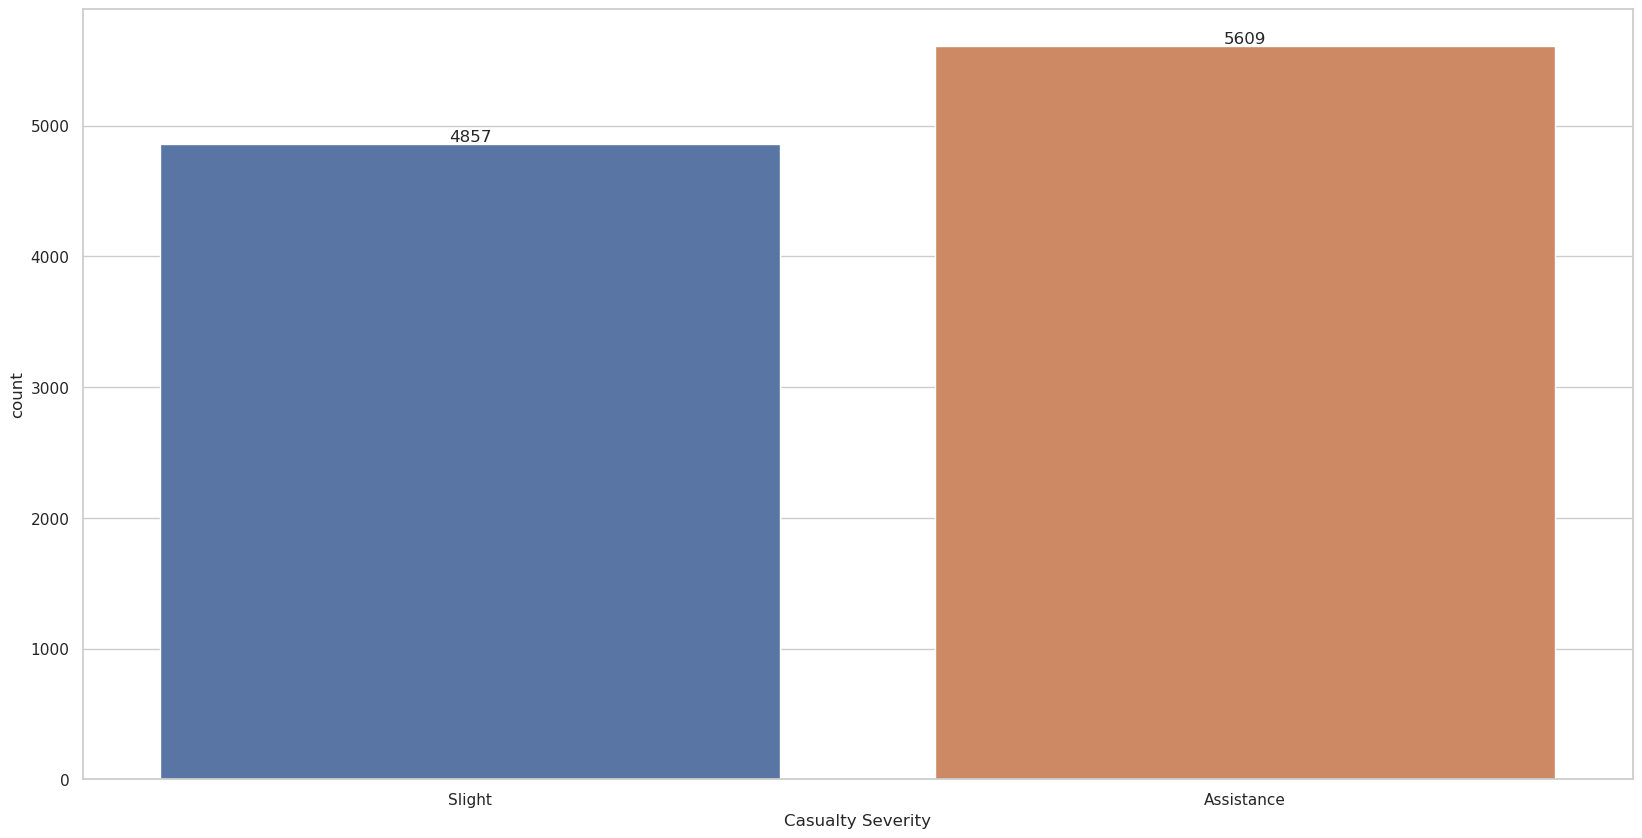

In [51]:
data_type = 'original'
save_histogram(city_name, data_frame[target_class], data_type)

# TEST

## Filter areas

In [52]:
x_name = 'Easting'
y_name = 'Northing'

data_frame[x_name] = data_frame[x_name].astype(int)
data_frame[y_name] = data_frame[y_name].astype(int)

casualty_name = 'Casualty Severity'
casualty_target_names = ['Assistance']

In [58]:
# 8
from src.data import remove_outliers

data_frame = remove_outliers(data_frame, x_name, y_name)

In [59]:
from src.data import get_intervals
from src.data import get_divisible_numbers

interval_x, interval_y = get_intervals(data_frame, x_name, y_name)

print('X')
get_divisible_numbers(interval_x)
print('Y')
get_divisible_numbers(interval_y)

X
Area units: 1, regions: 714995.0
Area units: 5, regions: 142999.0
Area units: 29, regions: 24655.0
Area units: 145, regions: 4931.0
Area units: 4931, regions: 145.0
Area units: 24655, regions: 29.0
Area units: 142999, regions: 5.0
Y
Area units: 1, regions: 508377.0
Area units: 3, regions: 169459.0
Area units: 97, regions: 5241.0
Area units: 291, regions: 1747.0
Area units: 1747, regions: 291.0
Area units: 5241, regions: 97.0
Area units: 169459, regions: 3.0


In [60]:
filename_to_load = f'{city_name}_victoria.csv'

In [61]:
from src.data import get_rows_by_removing_areas

# Birmingan
# x_offset = 211
# y_offset = 75

# Cornwall (UK)
# x_offset = 10
# y_offset = 8

# Southwark
# x_offset = 10 -> regions: 529
# y_offset = 20 -> regions: 487

# Tower
# 6 times remove feaures
# x_offset = 19, regions: 307.0
# y_offset = 25, regions: 246.0

x_offset = 145
y_offset = 97
new_dataframe = get_rows_by_removing_areas(data_frame,
                                           x_name = x_name,
                                           y_name = y_name,
                                           x_offset = x_offset,
                                           y_offset = y_offset,
                                           casualty_name = casualty_name,
                                           casualty_target_names = casualty_target_names)
new_dataframe.to_csv(filename_to_load)

100%|████████████████████████████████████████████████████████████| 5241/5241 [13:42<00:00,  6.37it/s]


In [62]:
filename_to_load 

'Victoria_victoria.csv'

In [63]:
filename_to_load = f'{city_name}_victoria.csv'
new_dataframe = pd.read_csv(filename_to_load, index_col=0)
new_dataframe_2 = new_dataframe
data_frame = new_dataframe_2.loc[:, ~new_dataframe_2.columns.isin(['longitude', 'latitude'])]

# new_dataframe.to_csv('test_uk.csv')

## Plot accidents

In [64]:
# # new_dataframe_2 = new_dataframe[new_dataframe['Casualty Severity'] == 'Assistance']
# from src.maps import plot_map

# latitude_name  = 'latitude'
# longitude_name = 'longitude'

# new_dataframe_2 = new_dataframe

# plot_map(new_dataframe_2,
#          latitude_name = latitude_name,
#          longitude_name = longitude_name,
#          color_by = casualty_name)


# END TEST

## Filtered Histogram

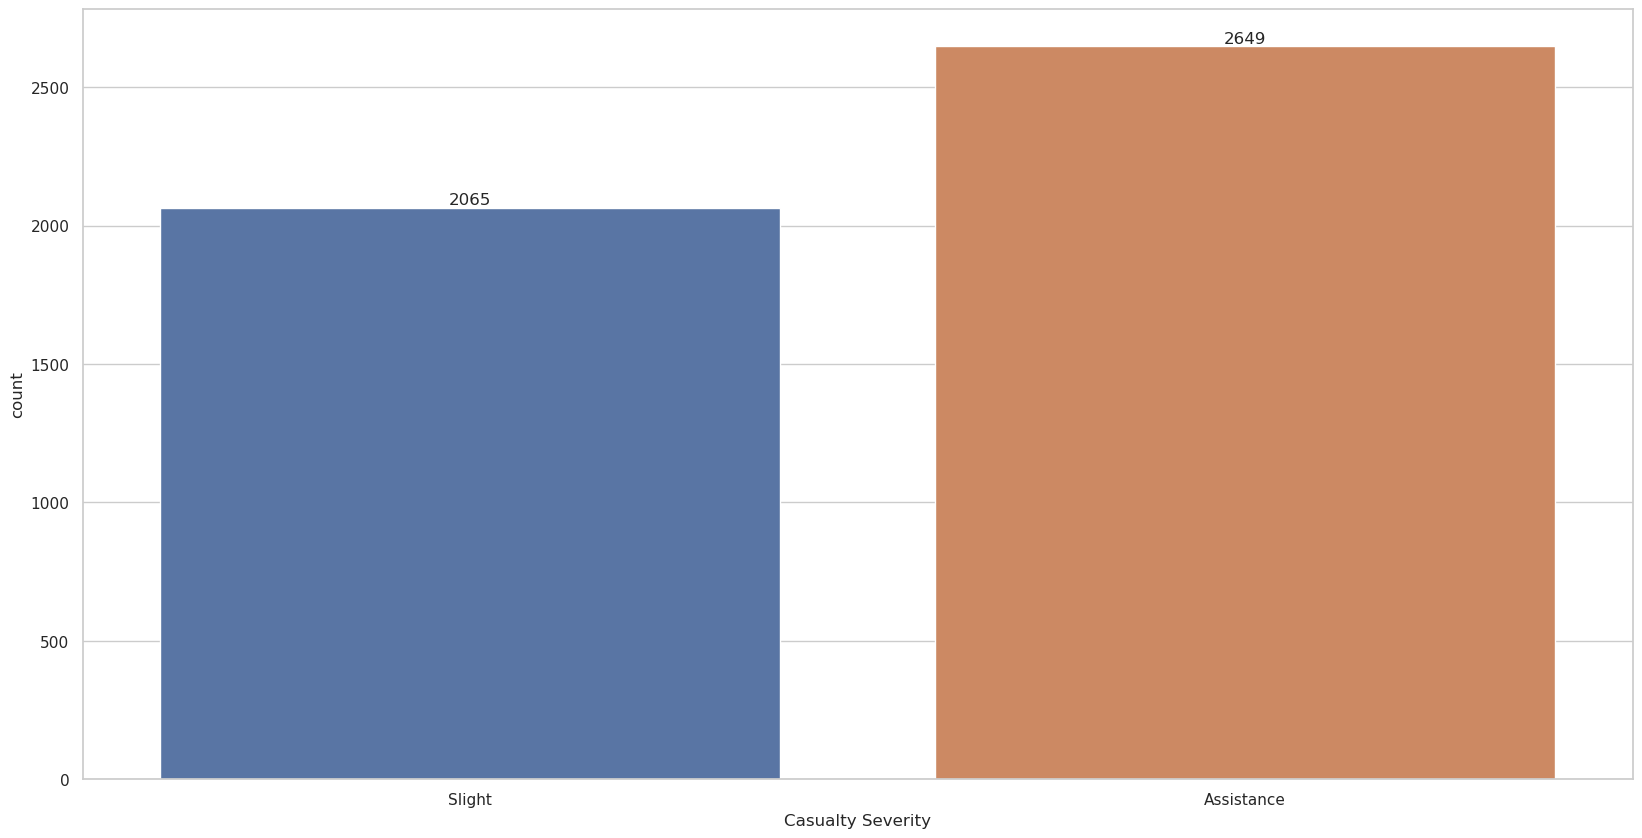

In [65]:
data_type = 'filtered'
save_histogram(city_name, data_frame[target_class], data_type)

## Split de datos

In [66]:
from sklearn.model_selection import train_test_split

Y = data_frame[target_class]

train, test = train_test_split(data_frame, test_size = 0.3)
X_train = X_train_original = train.loc[:, ~train.columns.isin([target_class])]
Y_train = Y_train_original = train[target_class]

X_test = test.loc[:, ~test.columns.isin([target_class])]
Y_test = test[target_class]

### Downsampling

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

slight_data  = train[train[target_class] == 'Slight']
serious_data = train[train[target_class] == 'Serious']
fatal_data   = train[train[target_class] == 'Fatal']

X_slight_downsampled  = resample(slight_data,
                                 replace = True,
                                 n_samples = len(fatal_data))

X_serious_downsampled = resample(serious_data,
                                 replace = True,
                                 n_samples = len(fatal_data))

downsampled_dataset = pd.concat([X_slight_downsampled, X_serious_downsampled, fatal_data])

# downsampled_train, downsampled_test = train_test_split(downsampled_dataset, test_size=0.2)

X_train_downsampled = downsampled_dataset.loc[:, ~downsampled_dataset.columns.isin([target_class])]
Y_train_downsampled = downsampled_dataset[target_class]

# X_test_downsampled = downsampled_test.loc[:, ~downsampled_test.columns.isin([target_class])]
# Y_test_downsampled = downsampled_test[target_class]

### Downsampled Histogram

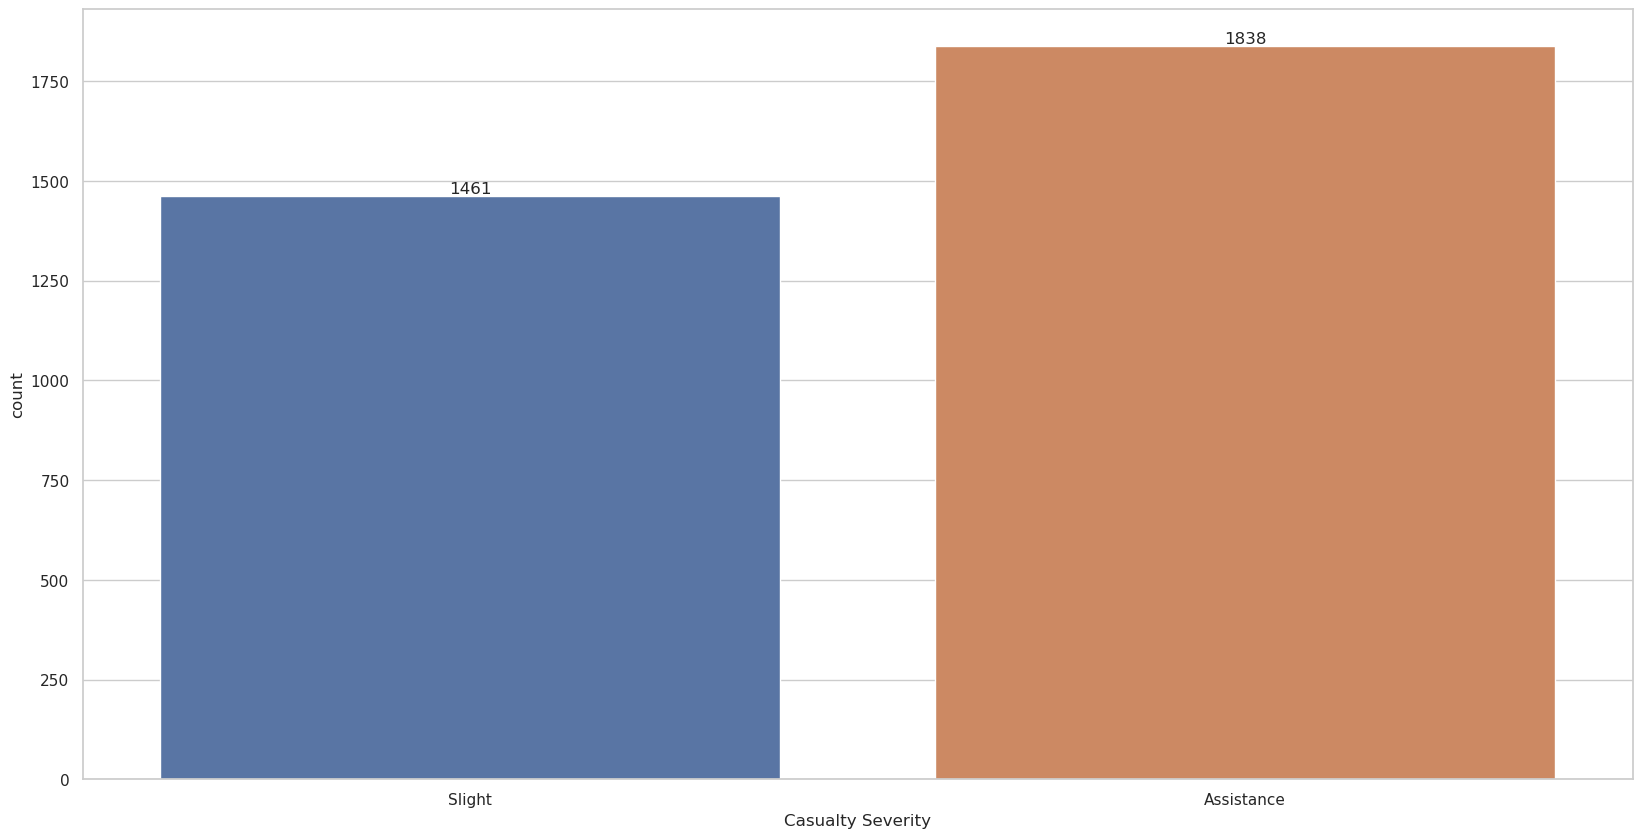

In [68]:
data_type = 'downsampled_train'
save_histogram(city_name, Y_train, data_type)

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
city = True
if city:
    slight_data  = train[train[target_class] == 'Slight']
    assistance_data = train[train[target_class] == 'Assistance']

    X_slight_downsampled  = resample(slight_data,
                                     replace = True,
                                     n_samples = len(assistance_data))


    downsampled_dataset = pd.concat([X_slight_downsampled, assistance_data])

    # downsampled_train, downsampled_test = train_test_split(downsampled_dataset, test_size=0.2)


    X_train_downsampled = downsampled_dataset.loc[:, ~downsampled_dataset.columns.isin([target_class])]
    Y_train_downsampled = downsampled_dataset[target_class]

    # X_test_downsampled = downsampled_test.loc[:, ~downsampled_test.columns.isin([target_class])]
    # Y_test_downsampled = downsampled_test[target_class]

In [70]:
# fv2gi(feature_vector)
# sorted(feature_vector.items(), key = lambda item: item[0][1])

# for item in feature_vector['Accident Features'].items():
#     print(item[1])

# feature_vector[parent_key].items()

# sorted(feature_vector['Accident Features'].items(), key = lambda item: item,
#                                reverse = True)

# print(feature_vector['Accident Features']['feature_weights'])

# fv = np.array(feature_vector['Accident Features']['feature_childs'])
# list(fv[indexes])

## Normalización de datos

In [71]:
# !conda install -c conda-forge imbalanced-learn

In [72]:
data_frame

,Easting,Northing,1st Road Class,Number of Vehicles,Road Surface,Speed Limit,Lighting Conditions,Weather Conditions,dia_semana,semana_en_año,Type of Vehicle,Age of Vehicle,First Point of Impact,Casualty Class,Sex of Casualty,Age of Casualty,Casualty Severity,Accident Time Sin,Accident Time Cos
4014,2579282,2302242,0,1,1,100,1,1,2,48,4,2005,6,2,0,3,Assistance,-8.870108e-01,-0.461749
4041,2593424,2304909,0,2,1,100,1,1,7,47,1,1998,4,3,0,3,Slight,3.826834e-01,-0.923880
4042,2593424,2304909,0,2,1,100,1,1,7,47,1,1998,4,3,1,2,Assistance,3.826834e-01,-0.923880
4043,2593424,2304909,0,2,1,100,1,1,7,47,1,1998,4,2,0,2,Slight,3.826834e-01,-0.923880
5848,2385725,2306720,0,1,1,80,9,1,5,50,2,1995,4,2,0,2,Assistance,-4.361939e-02,0.999048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10434,2236475,2808547,4,3,1,50,3,1,3,46,10,1988,1,2,0,2,Slight,-6.755902e-01,0.737277
10435,2236475,2808547,4,3,1,50,3,1,3,46,2,1988,1,2,0,2,Slight,-6.755902e-01,0.737277
5792,2229170,2809734,0,1,1,60,5,1,3,51,1,1991,4,3,0,1,Assistance,9.659258e-01,0.258819
5793,2229170,2809734,0,1,1,60,5,1,3,51,1,1991,4,2,1,1,Assistance,9.659258e-01,0.258819


In [73]:
if city:
    X_train = X_train.astype(int)
    X_test  = X_test.astype(int)
    X_train_downsampled = X_train_downsampled.astype(int)
    # X_test_downsampled  = X_test_downsampled.astype(int)

    X_train = normalize_data(X_train)
    X_test  = normalize_data(X_test)
    X_train_downsampled = normalize_data(X_train_downsampled)
    # X_test_downsampled  = normalize_data(X_test_downsampled)

    X_train_original = X_train_original.astype(int)
    X_train_original = normalize_data(X_train_original)

## Oversamplig de datos

In [74]:
# print('********** Train Before OverSampling **********')
# print('Slight: ', (Y_train == 'Slight').sum())
# print('Serious:', (Y_train == 'Serious').sum())
# print('Fatal:  ', (Y_train == 'Fatal').sum())
# print('\n Total X:', len(X_train), ' Total Y:', len(Y_train), '\n')

# X_train, Y_train = oversample_data(X_train, Y_train)

# print('********** Test **********')
# print('Slight: ', (Y_test == 'Slight').sum())
# print('Serious:', (Y_test == 'Serious').sum())
# print('Fatal:  ', (Y_test == 'Fatal').sum())
# print('\n Total X:', len(Y_test), ' Total Y:', len(Y_test), '\n')

In [75]:
if city:
    print('********** Train Before OverSampling **********')
    print('Slight: ', (Y_train == 'Slight').sum())
    print('Assistance:  ', (Y_train == 'Assistance').sum())
    print('\n Total X:', len(X_train), ' Total Y:', len(Y_train), '\n')

    X_train, Y_train = oversample_data(X_train, Y_train)

    print('********** Test **********')
    print('Slight: ', (Y_test == 'Slight').sum())
    print('Assistance:  ', (Y_test == 'Assistance').sum())
    print('\n Total X:', len(Y_test), ' Total Y:', len(Y_test), '\n')

********** Train Before OverSampling **********
Slight:  1461
Assistance:   1838

 Total X: 3299  Total Y: 3299 

********** After OverSampling **********
Slight:  1838
Assistance: 1838

 Total X:  3676  Total Y:  3676 

********** Test **********
Slight:  604
Assistance:   811

 Total X: 1415  Total Y: 1415 



### OVersampled Histogram

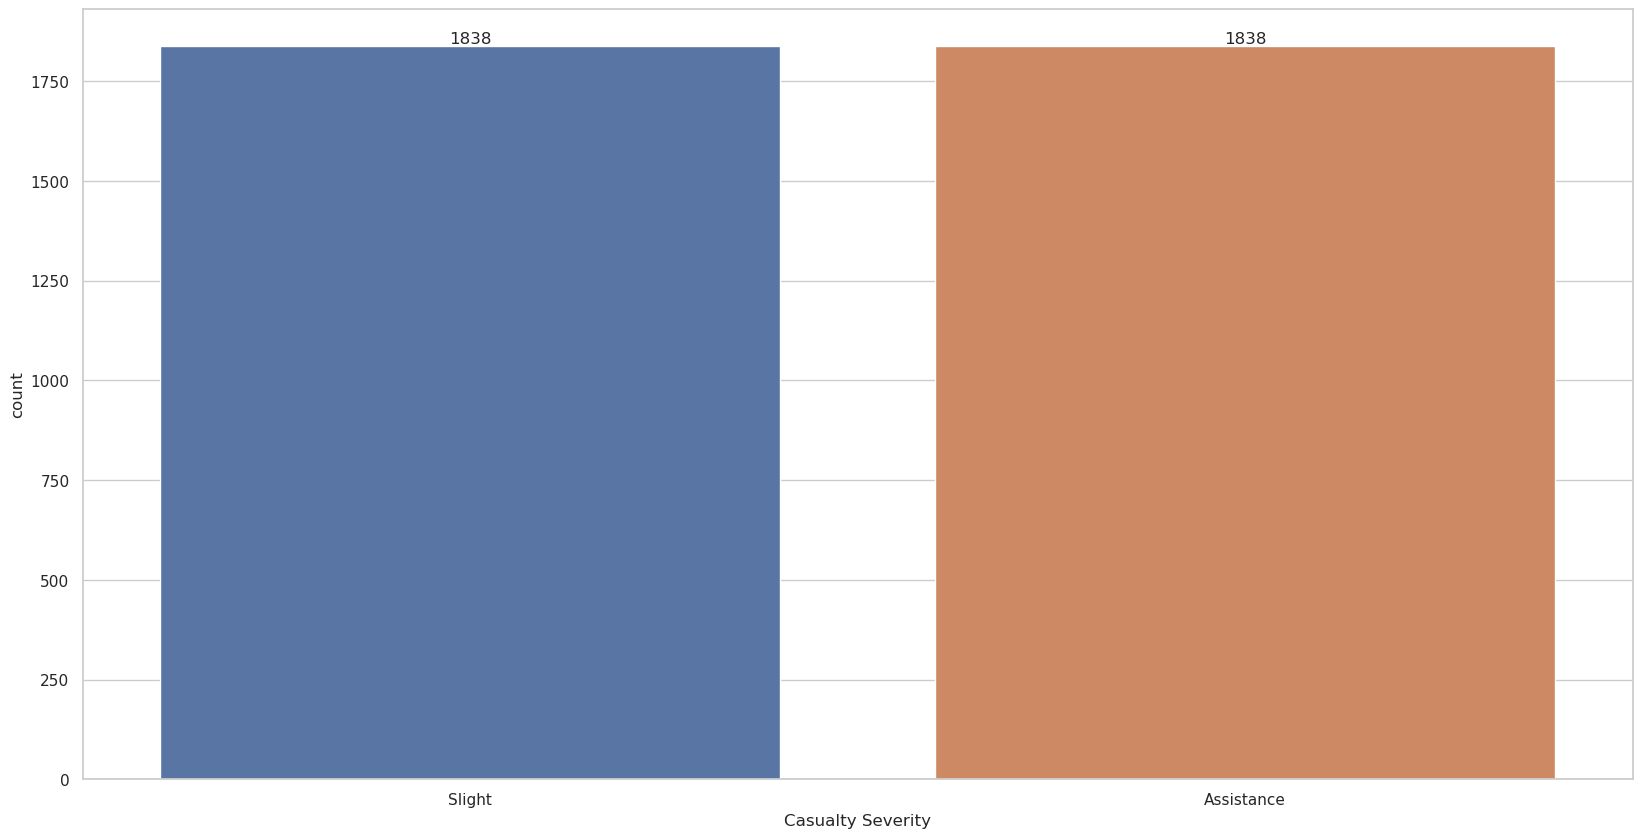

In [76]:
data_type = 'oversampled_train'
save_histogram(city_name, Y_train, data_type)

## XGBoost

In [77]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

### Genético

In [78]:
data_frame['Casualty Severity']

4014     Assistance
4041         Slight
4042     Assistance
4043         Slight
5848     Assistance
            ...    
10434        Slight
10435        Slight
5792     Assistance
5793     Assistance
6721     Assistance
Name: Casualty Severity, Length: 4714, dtype: object

In [79]:
if city:
    casualty_to_one_hot(Y_train)
    Y_train

In [80]:
# SEVERITY_TYPE_REPLACE = {'Slight': 0,
#                          'Assistance': 1
#                         }

# Y_train.replace(SEVERITY_TYPE_REPLACE, inplace = True)
# Y_train_downsampled.replace(SEVERITY_TYPE_REPLACE, inplace = True)
# Y_test.replace(SEVERITY_TYPE_REPLACE, inplace = True)

In [81]:
import xgboost as xgb
import random

if city and calculate_weights:
    casualty_to_one_hot(Y_train)
    casualty_to_one_hot(Y_train_downsampled)
    casualty_to_one_hot(Y_test)

    populationSize = (number_of_individuals, number_of_hyperparams)
    population = initialize_population(number_of_individuals   = number_of_individuals,
                                       hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE)

    fitnessHistory = np.empty([number_of_generations+1, number_of_individuals]) # Define an array to store the value of each parameter for each parent and generation
    populationHistory = np.empty([(number_of_generations+1)*number_of_individuals, number_of_hyperparams]) # Insert the value of initial parameters in history

    best_solution_history = np.empty([(number_of_generations), number_of_hyperparams+1])
    populationHistory[0:number_of_individuals,:] = population

    dtrain = xgb.DMatrix(data  = X_train_downsampled,
                         label = Y_train_downsampled)

    dtest  = xgb.DMatrix(data  = X_test, 
                         label = Y_test)

    for generation in range(number_of_generations):

        print("This is number %s generation" % (generation))

        new_population = []

        unique_individuals = np.unique(population, axis=0)

        new_individuals_to_create = number_of_individuals - len(unique_individuals)

        for i in range(new_individuals_to_create):
            new_individual = generate_individual(hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE)
            new_population.append(new_individual)

        new_population = np.array(new_population)

        if (new_individuals_to_create):
            population = np.concatenate((unique_individuals, new_population), axis=0)

        # print(f'Current population is {population}')
        print(f'New population is {len(new_population)}')

        # Train the dataset and obtain fitness
        fitnessValue = train_population(population = population,
                                        hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE,
                                        dMatrixTrain = dtrain,
                                        dMatrixTest = dtest,
                                        Y_test = Y_test)

        fitnessHistory[generation,:] = fitnessValue

        # Best score in the current iteration
        max_score_index = np.argmax(fitnessHistory[generation,:])
        max_score_value = np.max(fitnessHistory[generation,:])
        max_score_solution = population[max_score_index]

        max_solution_with_score = []
        max_solution_with_score = np.append(max_score_solution, max_score_value)
        best_solution_history[generation] = max_solution_with_score

        print(f"Best F1 score in the this iteration = {max_score_value}, best solution {max_score_solution}") # Survival of the fittest - take the top parents, based on the fitness value and number of parents needed to be selected

        parents = new_parents_selection(population = population,
                                        fitness = fitnessValue,
                                        numParents = numberOfParentsMating)

        # Mate these parents to create children having parameters from these parents (we are using uniform crossover)
        children = crossover_uniform(parents = parents,
                                     childrenSize = (populationSize[0] - parents.shape[0], number_of_hyperparams))

        # Add mutation to create genetic diversity
        children_mutated = mutation(children,
                                    hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE)

        '''
        We will create new population, which will contain parents that where selected previously based on the
        fitness score and rest of them  will be children
        '''
        population[0:parents.shape[0], :] = parents # Fittest parents
        population[parents.shape[0]:, :]  = children_mutated # Children

        populationHistory[(generation+1)*number_of_individuals : (generation+1)*number_of_individuals + number_of_individuals , :] = population # Store parent information

    #Best solution from the final iteration

    fitness = train_population(population = population,
                               hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE,
                               dMatrixTrain = dtrain,
                               dMatrixTest = dtest,
                               Y_test = Y_test)

    fitnessHistory[generation+1, :] = fitness # index of the best solution
    bestFitnessIndex = np.where(fitness == np.max(fitness))[0][0]


    best_hyperparams = {}
    for n_param, hyperparam in enumerate(HYPERPARAMS_TO_OPTIMIZE):
        best_hyperparams[hyperparam] = population[bestFitnessIndex][n_param]

This is number 0 generation
New population is 0
Best F1 score in the this iteration = 0.7399, best solution [ 0.46 22.    1.5 ]
This is number 1 generation
New population is 19
Best F1 score in the this iteration = 0.742, best solution [ 0.28 20.    1.7 ]
This is number 2 generation
New population is 19
Best F1 score in the this iteration = 0.7449, best solution [4.0e-01 1.7e+01 1.0e-02]
This is number 3 generation
New population is 16
Best F1 score in the this iteration = 0.7463, best solution [4.0e-01 1.9e+01 1.0e-02]
This is number 4 generation
New population is 23
Best F1 score in the this iteration = 0.7505, best solution [4.0e-01 2.4e+01 1.0e-02]
This is number 5 generation
New population is 26
Best F1 score in the this iteration = 0.7505, best solution [4.0e-01 2.4e+01 1.0e-02]
This is number 6 generation
New population is 17
Best F1 score in the this iteration = 0.7505, best solution [4.0e-01 2.4e+01 1.0e-02]
This is number 7 generation
New population is 25
Best F1 score in the

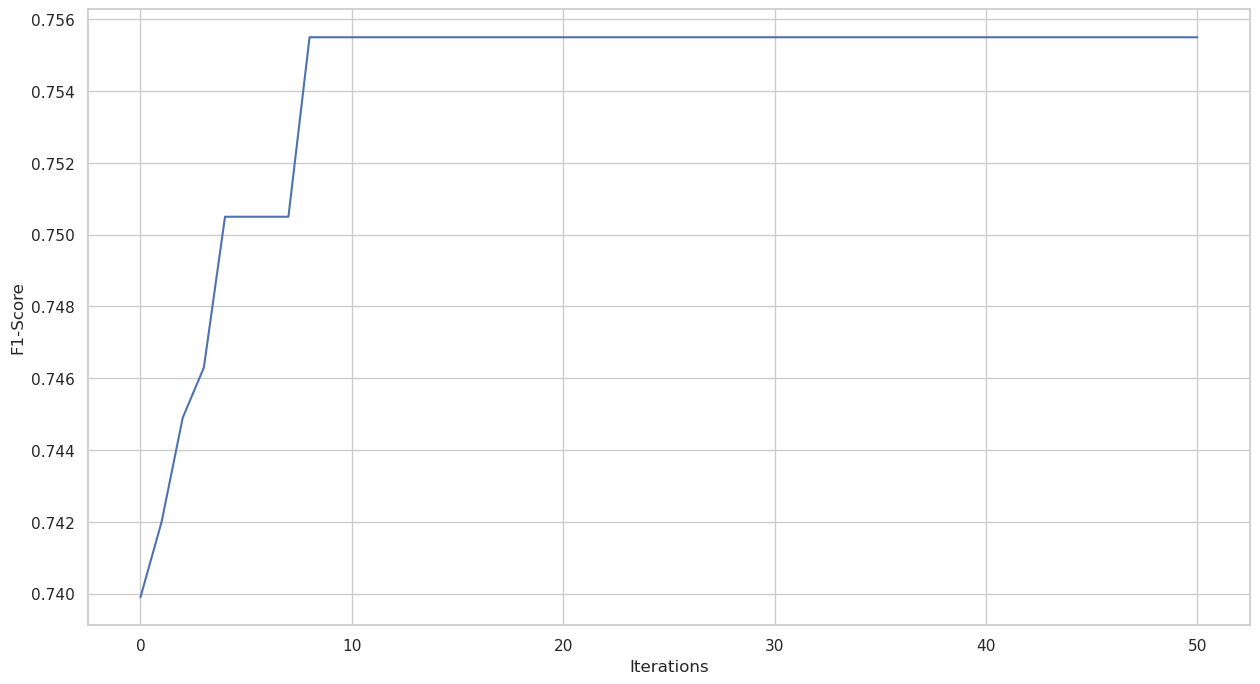

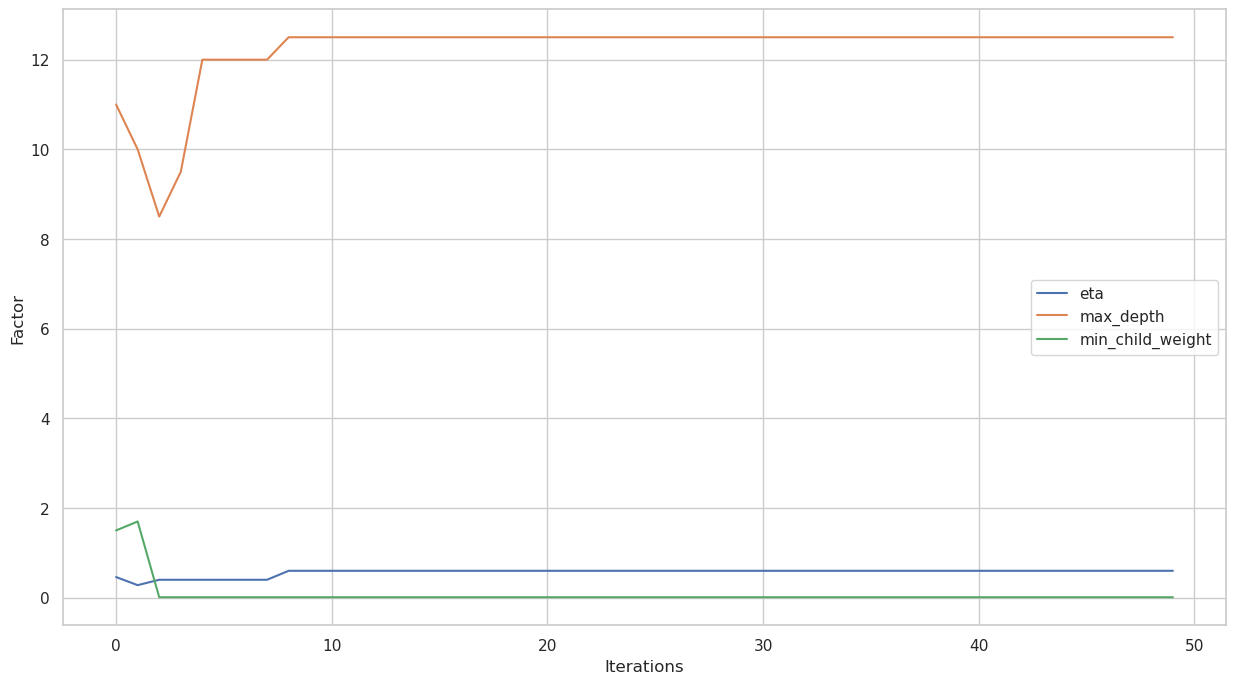

In [82]:
if calculate_weights and city:
    #### PLOT FITNESS EVOLUTION ####
    x_fitness = [np.max(fitnessHistory[i]) for i in range(0,fitnessHistory.shape[0])]

    FILE_NAME = f"{city_name}_ga_{MODEL_TIMESTAMP}.svg"

    plt.figure(figsize=(15, 8))
    plt.ylabel('F1-Score')
    plt.xlabel('Iterations')
    plt.plot(np.arange(len(x_fitness)), x_fitness)
    plt.savefig(GA_SCORES_PATH + FILE_NAME)

    #### PLOT HYPERPARAMS EVOLUTION ####
    FILE_NAME = f"{city_name}_ga_hyperparams_evolution_p{number_of_individuals}_c{numberOfParentsMating}_{MODEL_TIMESTAMP}.svg"

    LEGEND_LABELS = HYPERPARAMS_TO_OPTIMIZE.keys()

    plt.figure(figsize=(15, 8))
    best_solution_history_aux = best_solution_history
    best_solution_history_aux[:,1] = best_solution_history[:,1]/2
    best_solution_history_aux[:,3] = best_solution_history[:,3]/100
    plt.plot(best_solution_history_aux[:,:3])
    plt.ylabel('Factor')
    plt.xlabel('Iterations')
    plt.legend(LEGEND_LABELS)
    plt.savefig(HYPERPARAMS_EVOLUTON_PATH + FILE_NAME, dpi=300)

    FILE_NAME = f"{city_name}_population_p{number_of_individuals}_c{numberOfParentsMating}_{MODEL_TIMESTAMP}.txt"

    np.savetxt(FINAL_POPULATION_PATH + FILE_NAME, population, fmt='%s')

### Hiperparámetros

#### Carga hiperparámetros

In [83]:
if city and not calculate_weights:
    FILE_NAME = f"{city_name}_hyperparams{loaded_timestamp}.json"

    best_hyperparams = load_json(f"{HYPERPARAMS_PATH}{city_name}/", FILE_NAME)

# # # 0.04 2 6.5 --> 0.778
# best_hyperparams = {}
# best_hyperparams['eta'] = 0.1
# best_hyperparams['max_depth'] = 2
# best_hyperparams['min_child_weight'] = 1
# best_hyperparams['n_estimators'] = 583

# 1.00e-01 2.00e+00 1.00e+00 5.83e+02 --> 0.72

#### Cálculo de Hiperparámetros

In [84]:
# Y_train_onehot = casualty_to_one_hot(Y_train)
# Y_test_onehot  = casualty_to_one_hot(Y_test)

# space={'max_depth': hp.quniform("max_depth", 3, 25, 1),
#         'gamma': hp.uniform ('gamma', 1,9),
#         'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
#         'reg_lambda' : hp.uniform('reg_lambda', 0,1),
#         'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
#         'min_child_weight' : hp.quniform('min_child_weight', 0, 15, 1),
#         'n_estimators': hp.quniform('n_estimators', 100, 4000, 100),
#         'tree_method': 'gpu_hist'
#     }

# def objective(space):
#     clf = XGBClassifier(n_estimators = int(space['n_estimators']),
#                         max_depth = int(space['max_depth']),
#                         gamma = space['gamma'],
#                         reg_alpha = int(space['reg_alpha']),
#                         min_child_weight = int(space['min_child_weight']),
#                         colsample_bytree = int(space['colsample_bytree']),
#                         tree_method = space['tree_method']
#                        )
    
#     evaluation = [(X_train, Y_train), (X_test, Y_test)]
    
#     clf.fit(X_train, Y_train,
#             eval_set = evaluation, eval_metric = "auc",
#             early_stopping_rounds = 10, verbose = False)
            
    
#     pred = clf.predict(X_test)
#     accuracy = accuracy_score(Y_test, pred>0.5)
#     print ("SCORE:", accuracy)
#     return {'loss': -accuracy, 'status': STATUS_OK }


# trials = Trials()

# best_hyperparams = fmin(fn = objective,
#                         space = space,
#                         algo = tpe.suggest,
#                         max_evals = 100,
#                         trials = trials)

#### Escritura hiperparámetros

In [85]:
if calculate_weights and city:
    os.makedirs(f"{HYPERPARAMS_PATH}{city_name}", exist_ok=True)
    FILE_NAME = f"{city_name}_hyperparams{MODEL_TIMESTAMP}.json"

    write_json(best_hyperparams, f"{HYPERPARAMS_PATH}{city_name}/", FILE_NAME)

    print(best_hyperparams)

{'eta': 0.6000000000000001, 'max_depth': 25.0, 'min_child_weight': 0.01}


### Pesos de características

#### Carga definitiva/auxiliar de pesos

In [86]:
# best_hyperparams['objective'] = 'binary:logistic'
# best_hyperparams.pop('objective')
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])

In [87]:
# '2022-07-06-10:47:41'

#### Cálculo de pesos de caracetrísticas

In [88]:
import xgboost as xgb
import random

if calculate_weights and city:
    casualty_to_one_hot(Y_train)
    FILE_NAME = f"Liverpool_weights_paper-iii.json"
    
    feature_vector = load_json(WEIGHTS_PATH, FILE_NAME)
    xgboost = XGBClassifier(obj = 'binary:logistic',
                            **best_hyperparams,
                           
                            tree_method = tree_method,
                            single_precision_histogram =  True)

    xgboost.fit(X_train, Y_train)

    child_weights  = np.array(xgboost.feature_importances_)
    feature_vector = fill_feature_vector(X_train, child_weights)


#### Visualización pesos calculados

{'Easting': 10882.0, 'Northing': 6546.0, '1st Road Class': 1853.0, 'Number of Vehicles': 1700.0, 'Road Surface': 781.0, 'Speed Limit': 2428.0, 'Lighting Conditions': 895.0, 'Weather Conditions': 385.0, 'dia_semana': 2675.0, 'semana_en_año': 3568.0, 'Type of Vehicle': 2783.0, 'Age of Vehicle': 8759.0, 'First Point of Impact': 439.0, 'Casualty Class': 4062.0, 'Sex of Casualty': 1739.0, 'Age of Casualty': 5941.0, 'Accident Time Sin': 182.0, 'Accident Time Cos': 204.0}
Easting 0.03473528
Northing 0.04565134
1st Road Class 0.048300255
Number of Vehicles 0.10400859
Road Surface 0.03611606
Speed Limit 0.051379777
Lighting Conditions 0.042921998
Weather Conditions 0.11515399
dia_semana 0.050753605
semana_en_año 0.051734082
Type of Vehicle 0.018803533
Age of Vehicle 0.017981868
First Point of Impact 0.13529871
Casualty Class 0.074424736
Sex of Casualty 0.06575213
Age of Casualty 0.031818274
Accident Time Sin 0.04081644
Accident Time Cos 0.034349393


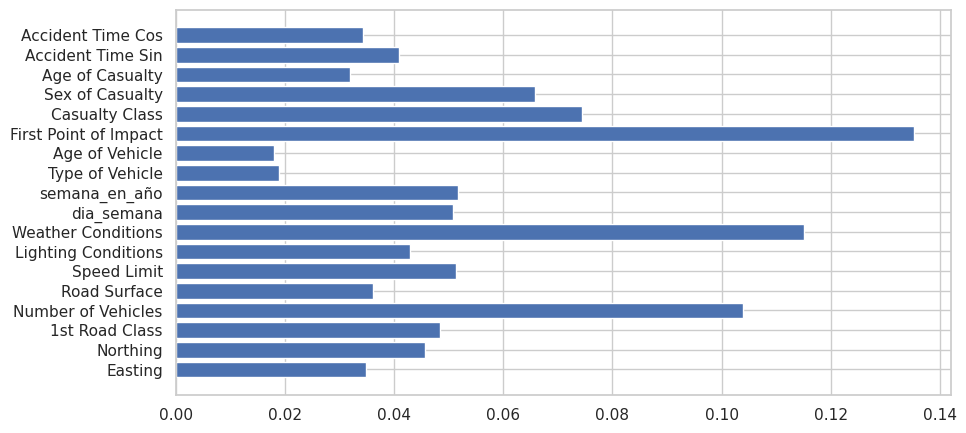

In [89]:
if calculate_weights and city:
    FILE_NAME = f"{city_name}_figure_weights_{MODEL_TIMESTAMP}.svg"

    print(xgboost.get_booster().get_score(importance_type= 'weight'))
    plt.figure(figsize=(10, 5))
    plt.barh(X_train.columns, xgboost.feature_importances_)
    plt.savefig(WEIGHTS_PATH + FILE_NAME)

    for column, weight in zip(X_train.columns,xgboost.feature_importances_):
      print(column, weight)

#### Escritura de pesos de características

In [90]:
if calculate_weights and city:    
    matrix_indexes = fv2gi(feature_vector)

    FILE_NAME = f"{city_name}_weights_{MODEL_TIMESTAMP}.json"
    # FILE_NAME = 'leeds_default_weights.json'

    write_json(feature_vector, WEIGHTS_PATH, FILE_NAME)
else:
    FILE_NAME = f"{city_name}_weights_paper-iii_{MODEL_TIMESTAMP}.json"
    
    feature_vector = load_json(WEIGHTS_PATH, FILE_NAME)

### Cálculo índices de matriz

In [91]:
if city:
    c = fv2gi(feature_vector)

## Construcción de imágenes

In [92]:
if city:
    max_dimension_x = len(feature_vector.keys())
    max_dimension_y = get_max_child_numbers(feature_vector)
    train_bgi = build_gray_images(X_train, max_dimension_x, max_dimension_y, matrix_indexes)
    train_original_bgi = build_gray_images(X_train_original, max_dimension_x, max_dimension_y, matrix_indexes)

    test_bgi  = build_gray_images(X_test, max_dimension_x, max_dimension_y, matrix_indexes)


    pd.DataFrame(train_bgi[:,:,1057])

3676
3299
1415


## Reshape de imágenes

In [93]:
if city:
    train_images = shape_images(X_data = X_train,
                            gray_images = train_bgi)
    test_images  = shape_images(X_data = X_test,
                                gray_images = test_bgi)


    train_original_images = shape_images(X_data = X_train_original,
                                         gray_images = train_original_bgi)

In [94]:
feature_vector

{'Accident Features': {'feature_childs': ['Easting',
   'Northing',
   '1st Road Class',
   'Number of Vehicles'],
  'feature_weights': ['0.03473528', '0.04565134', '0.048300255', '0.10400859'],
  'wpi': 0.232695465},
 'Roadway Features': {'feature_childs': ['Road Surface', 'Speed Limit'],
  'feature_weights': ['0.03611606', '0.051379777'],
  'wpi': 0.08749583699999999},
 'Environmental Features': {'feature_childs': ['Lighting Conditions',
   'Weather Conditions'],
  'feature_weights': ['0.042921998', '0.11515399'],
  'wpi': 0.158075988},
 'Vehicle Features': {'feature_childs': ['Type of Vehicle',
   'Age of Vehicle',
   'First Point of Impact'],
  'feature_weights': ['0.018803533', '0.017981868', '0.13529871'],
  'wpi': 0.17208411099999998},
 'Time Features': {'feature_childs': ['Accident Time Sin',
   'Accident Time Cos',
   'dia_semana',
   'semana_en_año'],
  'feature_weights': ['0.04081644',
   '0.034349393',
   '0.050753605',
   '0.051734082'],
  'wpi': 0.17765352},
 'Casualty Fe

<Figure size 640x480 with 0 Axes>

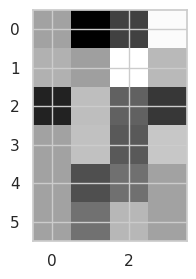

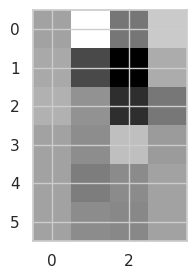

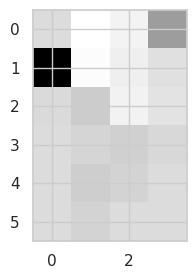

In [95]:
if city:
    plt.gray()
    for i in range(0,3):
        plt.figure(figsize=(3, 3))
        plt.imshow(train_bgi[:,:,i])
        # plt.savefig(f"{city_name}_image_example_{i}.svg",transparent=True)
        plt.show()

In [96]:
MODEL_TIMESTAMP

'2023-10-10-00:15:31'

In [97]:
# image = train_bgi[:,:,0]
# plt.figure(figsize=(6, 6))
# plt.imshow([image.flatten()])
# plt.savefig(f"test.svg",transparent=True, dpi=150)


In [98]:
# !conda install scikit-image

In [99]:
if city:
    # input_shape = (5, 5)

    array_train_images = np.asarray(train_images)
    array_test_images  = np.asarray(test_images)

    array_train_original_images = np.asarray(train_original_images)

In [100]:
# !conda install -c conda-forge tensorflow 

In [101]:
######### EN TERMINAL #########
# !pip install tensorflow-addons

## Visualización de datos

In [102]:
# !conda install seaborn

### Matriz de correlación

In [103]:
# correlation_matrix(X_test)

### PCA

In [104]:
# pca(X_train, X_test)

### TSNE

In [105]:
if city:
    n_samples = 150
    index_slight  = Y_train[Y_train == 'Slight'][:n_samples].index
    index_serious = Y_train[Y_train == 'Serious'][:n_samples].index
    index_fatal   = Y_train[Y_train == 'Fatal'][:n_samples].index

In [106]:
if city:
    # Get same number of class samples from SMOTEII
    X_slight_train_tsne  = X_train.loc[index_slight]
    X_serious_train_tsne = X_train.loc[index_serious]
    X_fatal_train_tsne   = X_train.loc[index_fatal]

    X_train_tsne = pd.concat([X_slight_train_tsne, X_serious_train_tsne, X_fatal_train_tsne])

    Y_slight_train_tsne  = Y_train[index_slight]
    Y_serious_train_tsne = Y_train[index_serious]
    Y_fatal_train_tsne   = Y_train[index_fatal]

    Y_train_tsne = pd.concat([Y_slight_train_tsne, Y_serious_train_tsne, Y_fatal_train_tsne])

In [107]:
if city:
    n_samples = len(Y_train_original[Y_train_original == 'Fatal'])

    index_slight  = Y_train_original[Y_train_original == 'Slight'][:n_samples].index
    index_serious = Y_train_original[Y_train_original == 'Serious'][:n_samples].index
    index_fatal   = Y_train_original[Y_train_original == 'Fatal'][:n_samples].index

In [108]:
if city:
    # Get same number of class samples from original
    X_slight_clean_tsne  = X_train_original.loc[index_slight]
    X_serious_clean_tsne = X_train_original.loc[index_serious]
    X_fatal_clean_tsne   = X_train_original.loc[index_fatal]

    X_clean_tsne = pd.concat([X_slight_clean_tsne, X_serious_clean_tsne, X_fatal_clean_tsne])

    Y_slight_clean_tsne  = Y_train_original[index_slight]
    Y_serious_clean_tsne = Y_train_original[index_serious]
    Y_fatal_clean_tsne   = Y_train_original[index_fatal]

    Y_clean_tsne = pd.concat([Y_slight_clean_tsne, Y_serious_clean_tsne, Y_fatal_clean_tsne])

In [109]:
if tsne and city:
    FILE_NAME = f"{TSNE_PATH}{city_name}/2d_{MODEL_TIMESTAMP}.svg"
    plot_TSNE(X_clean_tsne, Y_clean_tsne, n_components = 2, output_file_name = FILE_NAME, title = 'Muestras originales 2 Componentes')

    FILE_NAME = f"{TSNE_PATH}{city_name}/3d_tsne_test_{MODEL_TIMESTAMP}.svg"
    plot_TSNE(X_clean_tsne, Y_clean_tsne, n_components = 3, output_file_name = FILE_NAME, title = 'Muestras originales 3 Componentes')

    FILE_NAME = f"{TSNE_PATH}{city_name}/2d_tsne_train_{MODEL_TIMESTAMP}.svg"
    plot_TSNE(X_train_tsne, Y_train_tsne, n_components = 2, output_file_name = FILE_NAME, title = 'Muestras SMOTE-II 2 Componentes')

    FILE_NAME = f"{TSNE_PATH}{city_name}/3d_tsne_train_{MODEL_TIMESTAMP}.svg"
    plot_TSNE(X_train_tsne, Y_train_tsne, n_components = 3, output_file_name = FILE_NAME, title = 'Muestras SMOTE-II 3 Componentes')

### Autoencoder

#### Entrenamiento

In [110]:
# X_train = array_train_images
# X_test = array_test_images
# X_train_original = array_train_original_images

# X_train = X_train.reshape(len(array_train_images), 25)
# X_train_original = X_train_original.reshape(len(array_train_original_images), 25)
# X_test  = X_test.reshape(len(X_test), 25)

# autoencoder = autoencoder().fit(X_train, X_train,
#                                 epochs = 100,
#                                 batch_size = 128,
#                                 shuffle = True,
#                                 validation_data = (X_test, X_test))

#### Visualización

In [111]:
# # create encoder model
# encoder = Model(inputs=input_img, outputs=encoder2)
# encoder.summary()
# # create decoder model
# encoded_input = Input(shape=(3,))
# #lo que hace aqui es quedarse con las capas que corresponden al decodificador
# decoder_layer1 = autoencoder.layers[-2]
# decoder_layer2 = autoencoder.layers[-1]
# decoder = Model(inputs=encoded_input, outputs=decoder_layer2(decoder_layer1(encoded_input)))
# decoder.summary()
# # si miramos la salida, son simetricos el uno respecto al otro
# # encoder va de input a 3 y decoder de 3 a input

# # get latent vector for visualization
# latent_vector = encoder.predict(X_test)
# # # get decoder output to visualize reconstructed image
# # reconstructed_imgs = decoder.predict(latent_vector)


# # visualize in 3D plot
# from pylab import rcParams
# from mpl_toolkits.mplot3d import Axes3D

# rcParams['figure.figsize'] = 10, 8

# fig = plt.figure(1)
# ax = Axes3D(fig)

# xs = latent_vector[:, 0]
# ys = latent_vector[:, 1]
# zs = latent_vector[:, 2]

# color=['red','green','blue']

# for x, y, z, label in zip(xs, ys, zs, Y_test):
#     c = color[int(label)]
#     ax.text(x, y, z, label, backgroundcolor=c)
    
# ax.set_xlim(xs.min(), xs.max())
# ax.set_ylim(ys.min(), ys.max())
# ax.set_zlim(zs.min(), zs.max())

# plt.show()

# # X_test_encoded = encoder.predict(X_test, batch_size=32)
# # plt.figure(figsize=(6, 6))
# # plt.scatter(X_test_encoded[:, 0], X_test_encoded[:, 1], c=Y_test)
# # plt.colorbar()
# # plt.show()

## One-Hot

In [112]:
if city:
    Y_train_onehot = casualty_to_one_hot(Y_train)
    Y_train_original_onehot = casualty_to_one_hot(Y_train_original)
    Y_test_onehot  = casualty_to_one_hot(Y_test)

## Models

In [113]:
if city:
    array_train_images = np.asarray(train_images)
    # array_val_images   = np.asarray(val_images)
    array_test_images  = np.asarray(test_images)

    input_train_shape = (len(array_train_images), max_dimension_x, max_dimension_y, 1)
    # input_val_shape = (len(array_val_images), 5, 5, 1)
    input_test_shape  = (len(array_test_images), max_dimension_x, max_dimension_y, 1)

    array_train_images = array_train_images.reshape(input_train_shape)
    # array_val_images   = array_val_images.reshape(input_val_shape)
    array_test_images  = array_test_images.reshape(input_test_shape)

    Y_test_labels = one_hot_to_casualty(Y_test)

    from sklearn.utils import class_weight

    pesos = class_weight.compute_class_weight('balanced',
                                              classes = np.unique(Y_train_original),
                                              y = Y_train_original)


    print('\nPesos calculados:', pesos, '\n\n')


    # Keras espera un diccionario donde la clave sea el número de clase 
    # y el valor sea el peso calculado. 
    pesos = dict(enumerate(pesos))  


Pesos calculados: [1.12902122 0.89744287] 




In [114]:
import pickle
from joblib import dump, load

if city:
    times = pd.DataFrame()

### NB

In [115]:
MODEL_NAME = MODELS_NAME[0]

MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.joblib"

sns.reset_defaults()

#### Entrenamiento

In [116]:
from sklearn.naive_bayes import GaussianNB

if city and train_nn and other_models:
    start = time.time()

    gnb = GaussianNB()
    gnb = gnb.fit(X_train, Y_train)

    end = time.time()

    ellapsed_time = round(end - start, 2)

    model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
    times = pd.concat([times, model_time])


    print(f"Done! {MODEL_NAME} in {ellapsed_time} (s)")

Done! nb in 0.0 (s)


#### Escritura del modelo

In [117]:
if city and train_nn and other_models:
    os.makedirs(MODEL_PATH, exist_ok = True)

    dump(gnb, MODEL_PATH + MODEL_FILE_NAME) 

#### Carga de modelo pre-entrenado

In [118]:
if city and not train_nn and other_models:

    gnb = load(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [119]:
if city and other_models:
    print("[INFO] evaluating model...")
    if train_nn:
        Y_train_predicted = gnb.predict(X_train)
        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')
    Y_predicted = gnb.predict(X_test)

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

[INFO] evaluating model...
              precision  recall  f1-score   support
Assistance        0.694   0.340     0.457  1838.000
Slight            0.563   0.850     0.678  1838.000
accuracy          0.595   0.595     0.595     0.595
macro avg         0.629   0.595     0.567  3676.000
weighted avg      0.629   0.595     0.567  3676.000
              precision  recall  f1-score  support
Assistance        0.787   0.342     0.476   811.00
Slight            0.498   0.876     0.635   604.00
accuracy          0.570   0.570     0.570     0.57
macro avg         0.642   0.609     0.556  1415.00
weighted avg      0.663   0.570     0.544  1415.00


### SVC

In [120]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

MODEL_NAME = MODELS_NAME[1]

MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

In [121]:
if city and train_nn and other_models:
    start = time.time()

    clf = SVC(gamma='auto')
    clf.fit(X_train, Y_train)

    end = time.time()

    ellapsed_time = round(end - start, 2)


    model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
    times = pd.concat([times, model_time])

    print(f"Done! {MODEL_NAME} in {ellapsed_time} (s)")

Done! svc in 0.22 (s)


#### Escritura del modelo

In [122]:
if city and train_nn and other_models:
    os.makedirs(MODEL_PATH, exist_ok = True)

    dump(clf, MODEL_PATH + MODEL_FILE_NAME) 

#### Carga de modelo pre-entrenado

In [123]:
if city and not train_nn and other_models:
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{timestamp_load}.joblib"

    clf = load(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [124]:
if city and train_nn and other_models:
    print("[INFO] evaluating model...")

    if train_nn:
        Y_train_predicted = clf.predict(X_train)
        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')

    Y_predicted = clf.predict(X_test)

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

[INFO] evaluating model...
              precision  recall  f1-score  support
Assistance        0.737   0.622     0.675   1838.0
Slight            0.673   0.778     0.722   1838.0
accuracy          0.700   0.700     0.700      0.7
macro avg         0.705   0.700     0.698   3676.0
weighted avg      0.705   0.700     0.698   3676.0
              precision  recall  f1-score   support
Assistance        0.769   0.608     0.679   811.000
Slight            0.589   0.755     0.662   604.000
accuracy          0.671   0.671     0.671     0.671
macro avg         0.679   0.681     0.670  1415.000
weighted avg      0.692   0.671     0.672  1415.000


### KNN

In [125]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

MODEL_NAME = MODELS_NAME[2]

MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.joblib"

#### Entrenamiento

In [126]:
if city and train_nn and other_models:
    knn = KNeighborsClassifier(leaf_size = 7, n_neighbors = 91)

    start = time.time()

    knn.fit(X_train, Y_train)

    end = time.time()

    ellapsed_time = round(end - start, 2)

    model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
    times = pd.concat([times, model_time])

# leaf_size = list(range(1,10, 2))
# n_neighbors = list(range(1,100, 10))
# p = [1, 2]

# if city and train_nn and other_models:

#     start = time.time()

#     # Create new KNN object
#     hyperparameters = dict(leaf_size = leaf_size,
#                            n_neighbors = n_neighbors)

#     # Use GridSearch
#     knn_2 = KNeighborsClassifier(leaf_size = 7, n_neighbors = 91)

#     # Fit the model
#     clf = GridSearchCV(knn_2,
#                        hyperparameters,
#                        cv = 4)

#     knn = clf.fit(X_train, Y_train)

#     end = time.time()

#     ellapsed_time = round(end - start, 2)


#     model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
#     times = times.append(model_time)

#     # Print The value of best Hyperparameters

#     best_leaf_size  = knn.best_estimator_.get_params()['leaf_size']
#     best_n_neighbors = knn.best_estimator_.get_params()['n_neighbors']

#     print('Best leaf_size:', best_leaf_size)
#     print('Best n_neighbors:', best_n_neighbors)

#     df = pd.DataFrame({'best_leaf_size':[best_leaf_size], 'n_neighbors':[best_n_neighbors]})

#     FILE_NAME = f"{MODEL_NAME}/madrid_{MODEL_TIMESTAMP}.csv"

#     df.to_csv(HYPERPARAMS_PATH + FILE_NAME, index = True)

#### Escritura del modelo

In [127]:
if city and train_nn and other_models:

    MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.joblib"

    os.makedirs(MODEL_PATH, exist_ok = True)

    dump(knn, MODEL_PATH + MODEL_FILE_NAME) 

#### Carga de modelo pre-entrenado

In [128]:
# if city and not train_nn and other_models:

#     version = 'X'
#     MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
#     MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{model_version}.joblib"

#     knn = load(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [129]:
if city and train_nn and other_models:
    print("[INFO] evaluating model...")

    if train_nn:
        Y_train_predicted = knn.predict(X_train)
        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')
    Y_predicted = knn.predict(X_test)

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

[INFO] evaluating model...


/home/luis/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/luis/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. 

              precision  recall  f1-score   support
Assistance        0.670   0.490     0.566  1838.000
Slight            0.598   0.758     0.669  1838.000
accuracy          0.624   0.624     0.624     0.624
macro avg         0.634   0.624     0.617  3676.000
weighted avg      0.634   0.624     0.617  3676.000
              precision  recall  f1-score   support
Assistance        0.779   0.509     0.616   811.000
Slight            0.550   0.806     0.654   604.000
accuracy          0.636   0.636     0.636     0.636
macro avg         0.665   0.658     0.635  1415.000
weighted avg      0.682   0.636     0.632  1415.000


### Logistic Regression

In [130]:
from sklearn.linear_model import LogisticRegression

MODEL_NAME = MODELS_NAME[3]

MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

In [131]:
# train_nn = True

In [132]:
if city and train_nn and other_models:
    start = time.time()

    logistic_regression = LogisticRegression()  
    logistic_regression = logistic_regression.fit(X_train, Y_train)

    end = time.time()

    ellapsed_time = round(end - start, 2)


    model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
    times = pd.concat([times, model_time])

    print(f"Done! {MODEL_NAME} in {ellapsed_time} (s)")

Done! logistic_regression in 0.0 (s)


#### Escritura del modelo

In [133]:
if city and train_nn and other_models:

    os.makedirs(MODEL_PATH, exist_ok = True)
    dump(clf, MODEL_PATH + MODEL_FILE_NAME) 

#### Carga de modelo pre-entrenado

In [134]:
if city and not train_nn and other_models:
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{timestamp_load}.joblib"

    logistic_regression = load(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [135]:
if city and train_nn and other_models:
    print("[INFO] evaluating model...")

    if train_nn:

        Y_train_predicted = logistic_regression.predict(X_train)

        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')

    Y_predicted = logistic_regression.predict(X_test)

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

[INFO] evaluating model...
              precision  recall  f1-score   support
Assistance        0.603   0.548     0.575  1838.000
Slight            0.586   0.639     0.612  1838.000
accuracy          0.594   0.594     0.594     0.594
macro avg         0.595   0.594     0.593  3676.000
weighted avg      0.595   0.594     0.593  3676.000
              precision  recall  f1-score   support
Assistance        0.715   0.564     0.630   811.000
Slight            0.544   0.699     0.612   604.000
accuracy          0.621   0.621     0.621     0.621
macro avg         0.629   0.631     0.621  1415.000
weighted avg      0.642   0.621     0.622  1415.000


### Random Forest

In [136]:
from sklearn.linear_model import LogisticRegression

MODEL_NAME = MODELS_NAME[4]

MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

In [137]:
if city and train_nn and other_models:
    start = time.time()

    xgboost = XGBClassifier()
    xgboost = XGBClassifier(n_estimators=2, max_depth=2, eta=0.01, min_child_weight= 6.8)
# "eta": 0.01, "max_depth": 2.0, "min_child_weight": 6.8}
    xgboost.fit(X_train, Y_train)

    end = time.time()

    ellapsed_time = round(end - start, 2)


    model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
    times = pd.concat([times, model_time])

    print(f"Done! {MODEL_NAME} in {ellapsed_time} (s)")

Done! random_forest in 0.08 (s)


#### Escritura del modelo

In [138]:
if city and train_nn and other_models:
    os.makedirs(MODEL_PATH, exist_ok = True)

    dump(clf, MODEL_PATH + MODEL_FILE_NAME) 

#### Carga de modelo pre-entrenado

In [139]:
if city and not train_nn and other_models:
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{timestamp_load}.joblib"

    logistic_regression = load(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [140]:
if city and train_nn and other_models:
    print("[INFO] evaluating model...")

    if train_nn:

        Y_train_predicted = xgboost.predict(X_train)

        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')

    Y_predicted = xgboost.predict(X_test)

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

[INFO] evaluating model...
              precision  recall  f1-score   support
Assistance        0.867   0.238     0.373  1838.000
Slight            0.558   0.964     0.707  1838.000
accuracy          0.601   0.601     0.601     0.601
macro avg         0.713   0.601     0.540  3676.000
weighted avg      0.713   0.601     0.540  3676.000
              precision  recall  f1-score   support
Assistance        0.920   0.227     0.364   811.000
Slight            0.484   0.974     0.647   604.000
accuracy          0.546   0.546     0.546     0.546
macro avg         0.702   0.600     0.505  1415.000
weighted avg      0.734   0.546     0.485  1415.000


### MLP

In [141]:
from sklearn.neural_network import MLPClassifier

MODEL_NAME = MODELS_NAME[5]

MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

In [142]:
if city and train_nn and other_models:
    start = time.time()

    clf = MLPClassifier()

    clf.fit(X_train, Y_train)

    end = time.time()

    ellapsed_time = round(end - start, 2)


    model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
    times = pd.concat([times, model_time])

    print(f"Done! {MODEL_NAME} in {ellapsed_time} (s)")

Done! mlp in 1.83 (s)


/home/luis/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


#### Escritura del modelo

In [143]:
if city and train_nn and other_models:
    os.makedirs(MODEL_PATH, exist_ok = True)

    dump(clf, MODEL_PATH + MODEL_FILE_NAME) 

#### Carga de modelo pre-entrenado

In [144]:
if city and not train_nn and other_models:
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{timestamp_load}.joblib"

    clf = load(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [145]:
if city and train_nn and other_models:
    print("[INFO] evaluating model...")

    if train_nn:

        Y_predicted = clf.predict(X_train)

        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_predicted,
                                                         data = 'train')
    Y_predicted = clf.predict(X_test)

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

[INFO] evaluating model...
              precision  recall  f1-score   support
Assistance        0.808   0.743     0.774  1838.000
Slight            0.762   0.824     0.792  1838.000
accuracy          0.783   0.783     0.783     0.783
macro avg         0.785   0.783     0.783  3676.000
weighted avg      0.785   0.783     0.783  3676.000
              precision  recall  f1-score   support
Assistance        0.733   0.660     0.694   811.000
Slight            0.597   0.677     0.635   604.000
accuracy          0.667   0.667     0.667     0.667
macro avg         0.665   0.668     0.664  1415.000
weighted avg      0.675   0.667     0.669  1415.000


### Convolution 1D

In [146]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import TensorBoard

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

In [147]:
MODEL_NAME = MODELS_NAME[6]

MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

#### Entrenamiento

In [147]:
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [148]:
if city and train_nn and cnn1d and not calculate_cnn_hyperparams:
    
    fm_one, fm_two, fm_three, fm_four = (64, 512, 128, 256)
    n_classes = Y_train.unique()

    dense  = 256

    learnRate = 0.001

    batchSize = 64

    start = time.time()

    convolution_1d =  get_1d_conv(fm_one = fm_one,
                           fm_two = fm_two,
                           fm_three = fm_three,
                           fm_four = fm_four,
                           dense = dense,
                           dropout = 0.2,
                           learnRate = learnRate)

    history = convolution_1d.fit(array_train_images, Y_train_onehot,
                                   # class_weight = pesos,
                                   batch_size = batchSize,
                                   epochs = 50,
                                   shuffle = True,
                                   validation_data = (array_test_images, Y_test_onehot),
                                   callbacks=[tensorboard_callback])

    end = time.time()

    ellapsed_time = round(end - start, 2)

    model_time = pd.DataFrame({'city': [city_name],
                               'model': [MODEL_NAME],
                               'time': [ellapsed_time]})

    times = pd.concat([times, model_time])

    history

Epoch 1/50


ValueError: in user code:

    File "/home/luis/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/luis/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/luis/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/home/luis/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "/home/luis/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/luis/anaconda3/lib/python3.9/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 5, 5, 1), found shape=(None, 6, 4, 1)


In [ ]:
# if city and train_nn and cnn1d and not calculate_cnn_hyperparams:
#     start = time.time()

#     fold_no = 1
#     # for train, test in kfold.split(inputs, targets):
#     history = convolution_1d.fit(array_train_images, Y_train_onehot,
#                                  # class_weight = pesos,
#                                  batch_size = 64,
#                                  epochs = 100,
#                                  shuffle = True,
#                                  validation_data = (array_test_images, Y_test_onehot))
#     end = time.time()

#     ellapsed_time = round(end - start, 2)

#     model_time = pd.DataFrame({'city': [city_name],
#                                'model': [MODEL_NAME],
#                                'time': [ellapsed_time]})

#     times = times.append(model_time)

#     history

In [ ]:
# if city and train_nn and not calculate_cnn_hyperparams:
    
#     fm_one, fm_two, fm_three, fm_four = (64, 512, 1024, 512)
#     n_classes = Y_train.unique()

#     dense  = 32

#     learnRate = 0.001

#     batchSize = 32

#     start = time.time()

#     convolution_1d = get_1d_conv(fm_one = fm_one,
#                            fm_two = fm_two,
#                            fm_three = fm_three,
#                            fm_four = fm_four,
#                            dense = dense,
#                            dropout = 0.2,
#                            learnRate = learnRate)

#     history = convolution_1d.fit(array_train_images, Y_train_onehot,
#                            # class_weight = pesos,
#                            batch_size = batchSize,
#                            epochs = 1,
#                            shuffle = True,
#                            validation_data = (array_test_images, Y_test_onehot))

#     end = time.time()

#     ellapsed_time = round(end - start, 2)

#     model_time = pd.DataFrame({'city': [city_name],
#                                'model': [MODEL_NAME],
#                                'time': [ellapsed_time]})
#     times = times.append(model_time)    

#     history

In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
calculate_cnn_hyperparams=True
if city and train_nn and cnn1d and calculate_cnn_hyperparams:

    model_time = pd.DataFrame({'city': [city_name],
                               'model': [MODEL_NAME],
                               'time': 0})
    times = times.append(model_time)
    # wrap our model into a scikit-learn compatible classifier
    print("[INFO] initializing model...")
    model = KerasClassifier(build_fn=get_1d_conv, verbose=10)

    # define a grid of the hyperparameter search space

    # fm_one = fm_two = fm_three = fm_four = fm_five = fm_six = [32, 64, 128, 256, 512]
    fm_one = fm_two = fm_three = fm_four = [32, 64, 128, 256, 512, 1024]

    dense  = [32, 64, 128, 256]

    learnRate = [0.1, 1e-2, 1e-3, 1e-4]

    batchSize = [32, 64, 128]

    epochs = [60]

    # create a dictionary from the hyperparameter grid
    grid = dict(
        fm_one = fm_one,
        fm_two = fm_two,
        fm_three = fm_three,
        fm_four = fm_four,
        dense = dense,
        learnRate=learnRate,
        batch_size=batchSize,
        epochs=epochs
    )

    # initialize a random search with a 3-fold cross-validation and then
    # start the hyperparameter search process
    print("[INFO] performing random search...")
    searcher = RandomizedSearchCV(estimator = model,
                                  n_iter = 50,
                                  cv = 3,
                                  param_distributions = grid,
                                  scoring = 'f1_micro')

    searchResults = searcher.fit(array_train_images, Y_train)

    # summarize grid search information
    bestScore = searchResults.best_score_
    bestParams = searchResults.best_params_

    print("[INFO] best score is {:.2f} using {}".format(bestScore,	bestParams))

    print("[INFO] evaluating the best model...")
    convolution1d = bestModel = searchResults.best_estimator_
    # accuracy = bestModel.score(array_test_images, Y_test)
    # print("accuracy: {:.2f}%".format(accuracy * 100))

    text_file = open(f"./CNN1D-{MODEL_TIMESTAMP}.txt", "w")
    n = text_file.write(str(searchResults.cv_results_))
    text_file.close()

#### Escritura del modelo

In [ ]:
if city and train_nn and cnn1d:
    os.makedirs(MODEL_PATH, exist_ok = True)

    convolution_1d.save(MODEL_PATH + MODEL_FILE_NAME)

#### Carga de modelo pre-entrenado

In [ ]:
if city and not train_nn and not laptop and cnn1d:
    # MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{loaded_timestamp}.h5"
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_2022-07-19-08:49:34.h5"
    # MODEL_FILE_NAME = 'madrid_convolution_1d_2022-05-19-06:33:55.h5'

    convolution_1d = tf.keras.models.load_model(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [ ]:
if city and cnn1d:

    print("[INFO] evaluating network...")

    Y_predicted = convolution_1d.predict(x = array_test_images).argmax(axis = 1)

    if train_nn:
        F1_SCORE_PATH = f"{F1_SCORES_PATH}{MODEL_NAME}/"
        F1_SCORE_NAME = f"{city_name}_{MODEL_NAME}_f1_score_{MODEL_TIMESTAMP}.svg"

        plot_f1_score_history(f1_score_path = F1_SCORE_PATH,
                              f1_score_name = F1_SCORE_NAME,
                              history = history)

        Y_train_predicted = convolution_1d.predict(x = array_train_images).argmax(axis = 1)

        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

### Convolution 2D

In [148]:
MODEL_NAME = MODELS_NAME[7]

MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

#### Entrenamiento

In [149]:

if city and cnn2d and not False:
    
    fm_one, fm_two, fm_three, fm_four = (256, 512, 256, 32)
    n_classes = Y_train.unique()

    dense  = 512

    learning_rate = 1e-05

    batchSize = 32

    start = time.time()

    tasp_cnn = get_tasp_cnn_o(max_dimension_x,
                              max_dimension_y,
                              fm_one = fm_one,
                              fm_two = fm_two,
                              fm_three = fm_three,
                              fm_four = fm_four,
                              dense = dense,
                              dropout = 0.2,
                              learning_rate = learning_rate)

    history = tasp_cnn.fit(array_train_images, Y_train_onehot,
                           # class_weight = pesos,
                           batch_size = batchSize,
                           epochs = 50,
                           shuffle = True,
                           validation_data = (array_test_images, Y_test_onehot))

    end = time.time()

    ellapsed_time = round(end - start, 2)

    model_time = pd.DataFrame({'city': [city_name],
                               'model': [MODEL_NAME],
                               'time': [ellapsed_time]})
    times = pd.concat([times, model_time])

    history

Epoch 1/50


2023-10-10 00:36:29.250611: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600


  1/115 [..............................] - ETA: 3:15 - loss: 0.7607 - f1_score: 0.6667

2023-10-10 00:36:29.619401: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-10-10 00:36:29.620333: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-10-10 00:36:29.620337: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2023-10-10 00:36:29.620364: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-10-10 00:36:29.691605: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] Tensor

115/115 [==============================] - 3s 9ms/step - loss: 0.7314 - f1_score: 0.6684 - val_loss: 0.6977 - val_f1_score: 0.6667
Epoch 2/50
115/115 [==============================] - 1s 5ms/step - loss: 0.6140 - f1_score: 0.6992 - val_loss: 0.7053 - val_f1_score: 0.6667
Epoch 3/50
115/115 [==============================] - 1s 5ms/step - loss: 0.5603 - f1_score: 0.7176 - val_loss: 0.6983 - val_f1_score: 0.6668
Epoch 4/50
115/115 [==============================] - 1s 5ms/step - loss: 0.5287 - f1_score: 0.7302 - val_loss: 0.6698 - val_f1_score: 0.6708
Epoch 5/50
115/115 [==============================] - 1s 7ms/step - loss: 0.4901 - f1_score: 0.7474 - val_loss: 0.6222 - val_f1_score: 0.6934
Epoch 6/50
115/115 [==============================] - 1s 9ms/step - loss: 0.4670 - f1_score: 0.7574 - val_loss: 0.6028 - val_f1_score: 0.7047
Epoch 7/50
115/115 [==============================] - 1s 6ms/step - loss: 0.4399 - f1_score: 0.7716 - val_loss: 0.5944 - val_f1_score: 0.7135
Epoch 8/50
115/11

In [150]:
with open(f'CNN2D_{MODEL_TIMESTAMP}.txt', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [151]:
# from kerastuner import RandomSearch
# #creating randomsearch object
# tuner = RandomSearch(build_model,
#                      objective='val_accuracy',
#                      max_trials = 5)
# # search best parameter
# tuner.search(train_df,train_labl,epochs=3,validation_data=(train_df,train_labl))

In [152]:
X_train_singled = array_train_images.reshape((len(array_train_images), -1))
X_train_singled

array([[ 0.00000000e+00, -8.79035180e-01, -5.25891229e-01, ...,
        -2.62849325e-01,  1.10748677e-01,  0.00000000e+00],
       [ 0.00000000e+00,  1.13761090e+00, -5.25891229e-01, ...,
        -2.62849325e-01, -3.15712422e-01,  0.00000000e+00],
       [ 0.00000000e+00,  1.13761090e+00,  7.19561150e-01, ...,
        -2.62849325e-01,  4.13340213e-03,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  9.91111684e-01, -5.25891229e-01, ...,
        -2.62849325e-01, -1.25717066e-01,  0.00000000e+00],
       [ 0.00000000e+00, -8.79035180e-01,  2.82394830e-01, ...,
        -2.62849325e-01, -2.09097147e-01,  0.00000000e+00],
       [ 0.00000000e+00, -3.07248913e-01, -5.25891229e-01, ...,
        -3.74936673e-02,  6.93334712e+00,  0.00000000e+00]])

https://www.google.com/search?channel=fs&client=ubuntu&q=gridsearch+sklearn+custom+validation


https://stackoverflow.com/questions/31948879/using-explicit-predefined-validation-set-for-grid-search-with-sklearn


https://scikit-learn.org/stable/modules/cross_validation.html#predefined-fold-splits-validation-sets


https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.PredefinedSplit.html#sklearn.model_selection.PredefinedSplit

In [153]:
from sklearn.preprocessing import OneHotEncoder

Y_train_array = np.asarray(Y_train)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = Y_train_array.reshape(len(Y_train_array), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
train_onehot_encoded = onehot_encoded.astype(int)

Y_test_array = np.asarray(Y_test)
integer_encoded = Y_test_array.reshape(len(Y_test_array), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
test_onehot_encoded = onehot_encoded.astype(int)

In [154]:
from sklearn.model_selection import PredefinedSplit

# -1 para train
# 0 para test
train_indexes = [-1] * array_train_images.shape[0]
test_indexes  = [0] * array_test_images.shape[0]

predefined_splitted_y_indexes = np.array(train_indexes + test_indexes)
predefined_splitted_x = np.concatenate((array_train_images, array_test_images), axis=0)
predefined_splitted_onehot = np.concatenate((train_onehot_encoded, test_onehot_encoded), axis=0)

ps = PredefinedSplit(predefined_splitted_y_indexes)

for i, (train_index, test_index) in enumerate(ps.split()):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[   0    1    2 ... 3673 3674 3675]
  Test:  index=[3676 3677 3678 ... 5088 5089 5090]


In [155]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

calculate_cnn_hyperparams=False
if city and cnn2d and calculate_cnn_hyperparams:

    model_time = pd.DataFrame({'city': [city_name],
                               'model': [MODEL_NAME],
                               'time': 0})

    times = pd.concat([times, model_time])
    # wrap our model into a scikit-learn compatible classifier
    print("[INFO] initializing model...")

    model = KerasClassifier(model=get_tasp_cnn_o, fm_one=1, fm_two=2, fm_three=3, fm_four=4,learning_rate=1, dense=1,epochs=10, batch_size=512, verbose=0)

    # define a grid of the hyperparameter search space

    # fm_one = fm_two = fm_three = fm_four = fm_five = fm_six = [32, 64, 128, 256, 512]
    fm_one = fm_two = fm_three = fm_four = [32, 64, 128, 256, 512, 1024]

    dense  = [32, 64, 128, 256, 512]

    learning_rate = [0.1, 1e-2, 1e-3, 1e-4, 1e-5]

    batchSize = [32, 64, 128, 256]

    epochs = [50]

    # create a dictionary from the hyperparameter grid
    grid = dict(
        fm_one = fm_one,
        fm_two = fm_two,
        fm_three = fm_three,
        fm_four = fm_four,
        dense = dense,
        learning_rate=learning_rate,
        batch_size=batchSize,
        epochs=epochs
    )

    number_of_configs = 150

    # initialize a random search with a 3-fold cross-validation and then
    # start the hyperparameter search process
    print("[INFO] performing random search...")
    searcher = RandomizedSearchCV(estimator = model,
                                  n_iter = number_of_configs,
                                  cv = ps,
                                  param_distributions = grid,
                                  scoring = 'f1_micro')

    searchResults = searcher.fit(predefined_splitted_x, predefined_splitted_onehot)

    # summarize grid search information
    bestScore = searchResults.best_score_
    bestParams = searchResults.best_params_

    print("[INFO] best score is {:.2f} using {}".format(bestScore,	bestParams))

    print("[INFO] evaluating the best model...")
    taspcnn = bestModel = searchResults.best_estimator_
    # accuracy = bestModel.score(array_test_images, Y_test)
    # print("accuracy: {:.2f}%".format(accuracy * 100))

    text_file = open(f"./CNN2D-{MODEL_TIMESTAMP}.txt", "w")
    n = text_file.write(str(searchResults.cv_results_))
    text_file.close()
    
    searchResults.best_estimator_.epochs

#### Escritura del modelo

In [156]:
if city and cnn2d:
    MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

    os.makedirs(MODEL_PATH, exist_ok = True)

    tasp_cnn.save(MODEL_PATH + MODEL_FILE_NAME)

#### Carga de modelo pre-entrenado

In [157]:
if city and not train_nn and cnn2d:
    # MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{timestamp_load}.joblib"
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_2022-07-19-08:49:34.h5"
    # MODEL_FILE_NAME = 'madrid_convolution_2d_2022-05-18-19:50:16.h5'

    tasp_cnn = tf.keras.models.load_model(MODEL_PATH + MODEL_FILE_NAME)

In [158]:
# ## Exportar los kernels

# n_samples = 3
# layers = [0, 2, 4, 6]

# for layer_number in layers:
#     filters, biases = tasp_cnn.layers[layer_number].get_weights()
    
#     layer_name = layer_number//2 + 1

#     for i in range(n_samples):
#         # X,Y, channel, filter_number
#         current_filter = filters[:,:,0, i]

#         plt.figure(figsize=(3, 3))
#         plt.grid(b = None)
#         plt.imshow(current_filter, cmap='gray')

#         # plt.savefig(f"filters/{city_name}_filter_layer_{layer_name}_{i}.svg", transparent=True)
#         plt.show()

In [159]:
# # import tf.keras.mo.Model
# tasp_cnn_feature_maps = tf.keras.models.Model(inputs = tasp_cnn.inputs, outputs=tasp_cnn.layers[0].output)

# tasp_cnn_feature_maps.predict(array_train_images[:3]).shape

In [160]:
# feature_maps = tasp_cnn.predict(array_train_images)
# # plot all 64 maps in an 8x8 squares
# square = 5
# ix = 1
# for _ in range(square):
#     for _ in range(square):
#         # specify subplot and turn of axis

#         # plot filter channel in grayscale
#         plt.imshow(tasp_cnn_feature_maps[ix-1,:,:,:], cmap='gray')
#         ix += 1
# # show the figure
# plt.show()

#### Resultados

[INFO] evaluating network...
45/45 [==============================] - 0s 750us/step


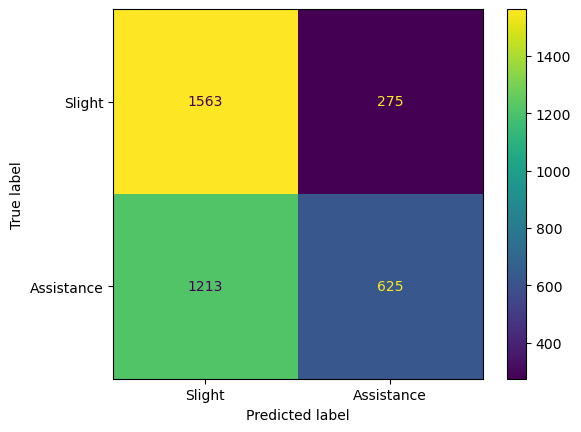

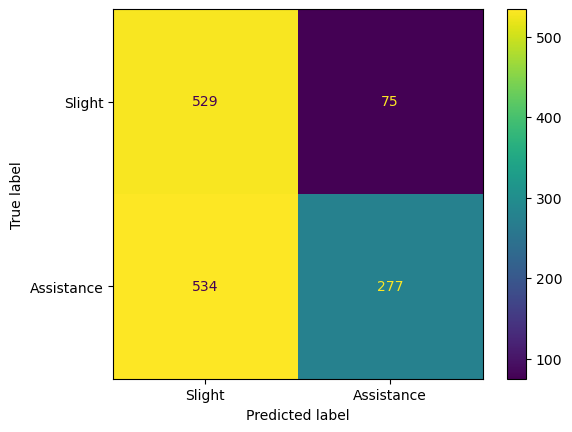

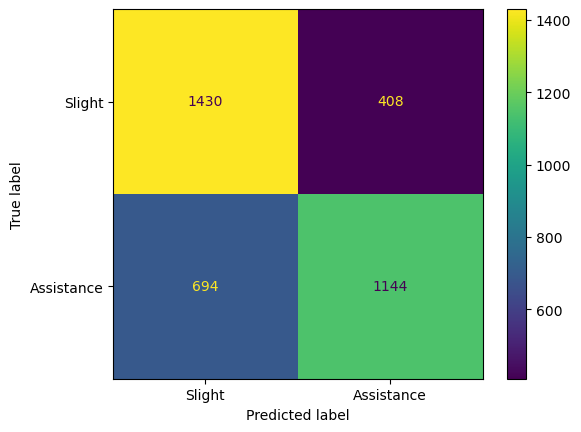

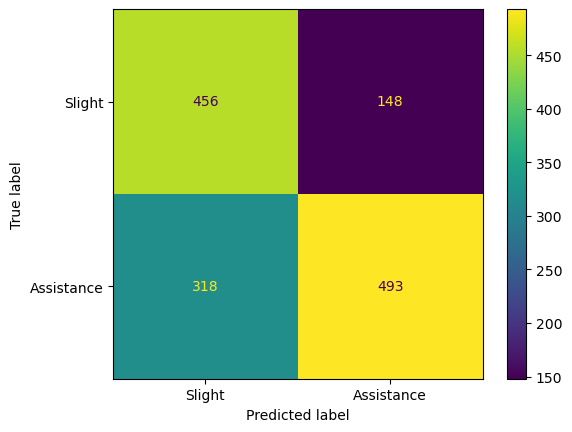

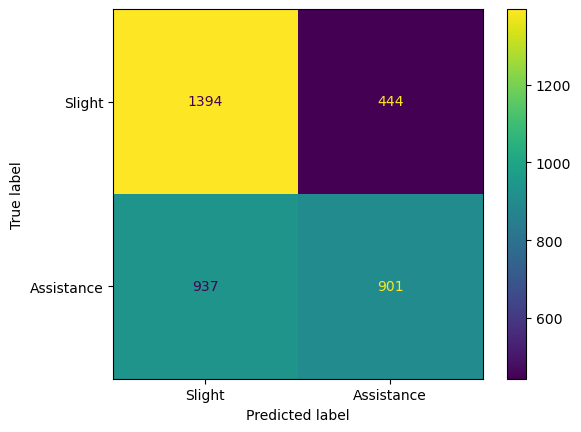

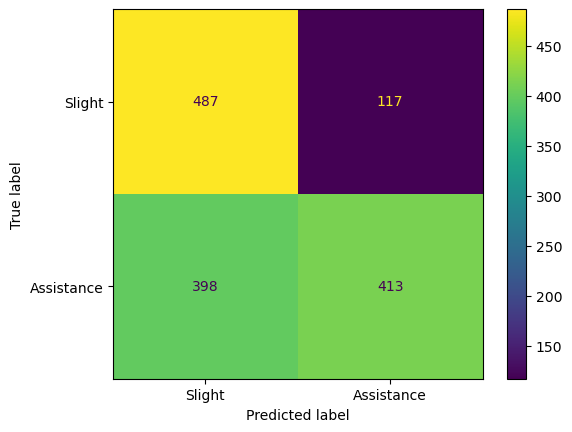

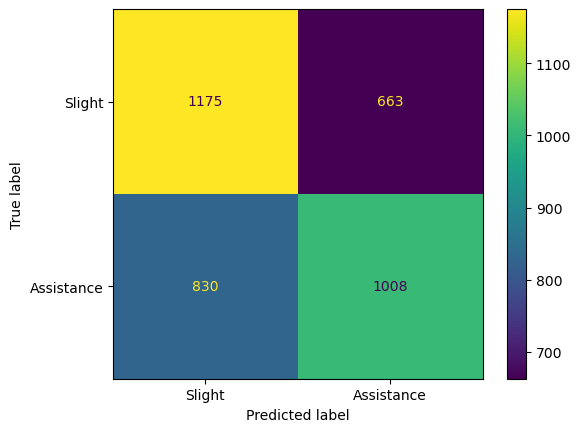

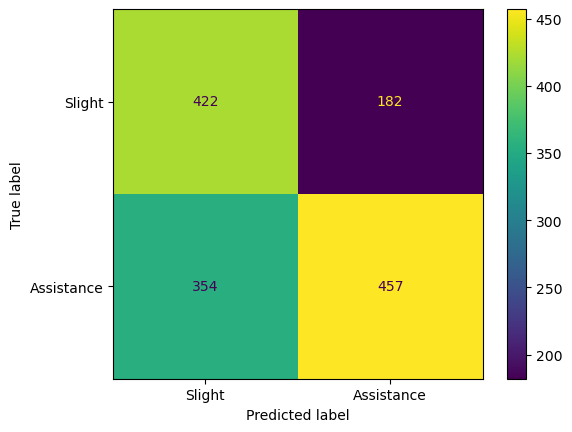

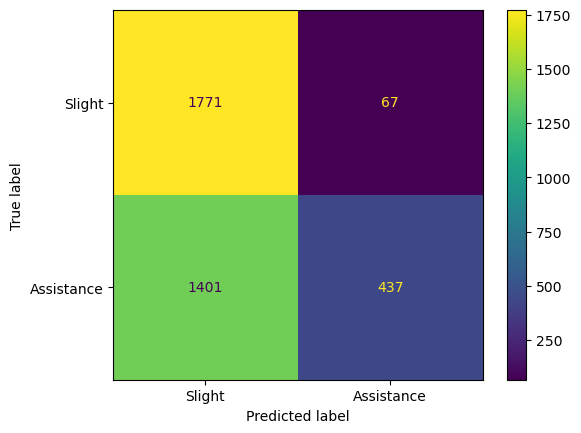

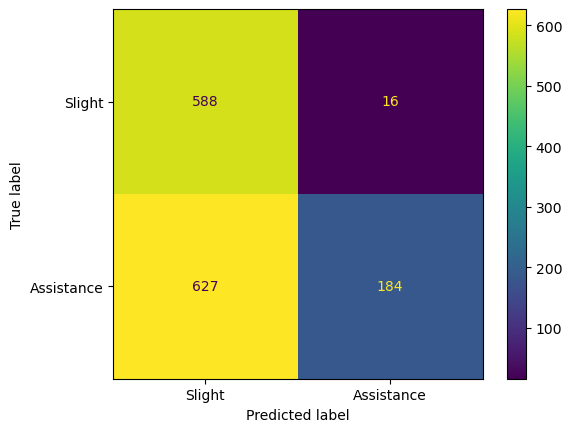

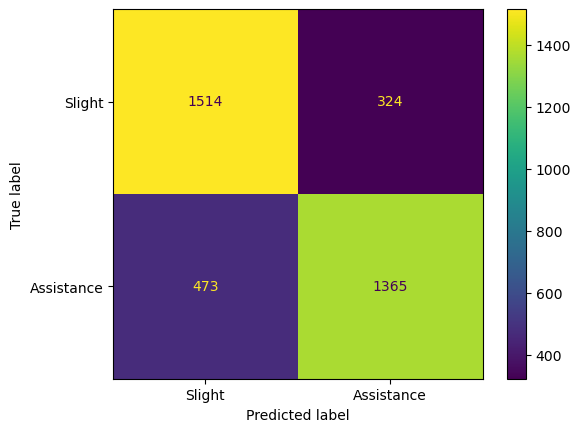

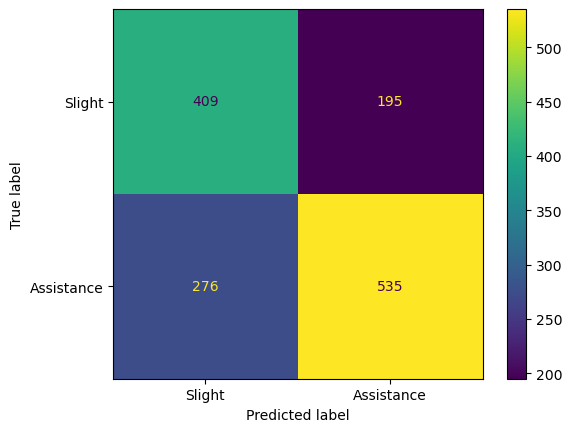

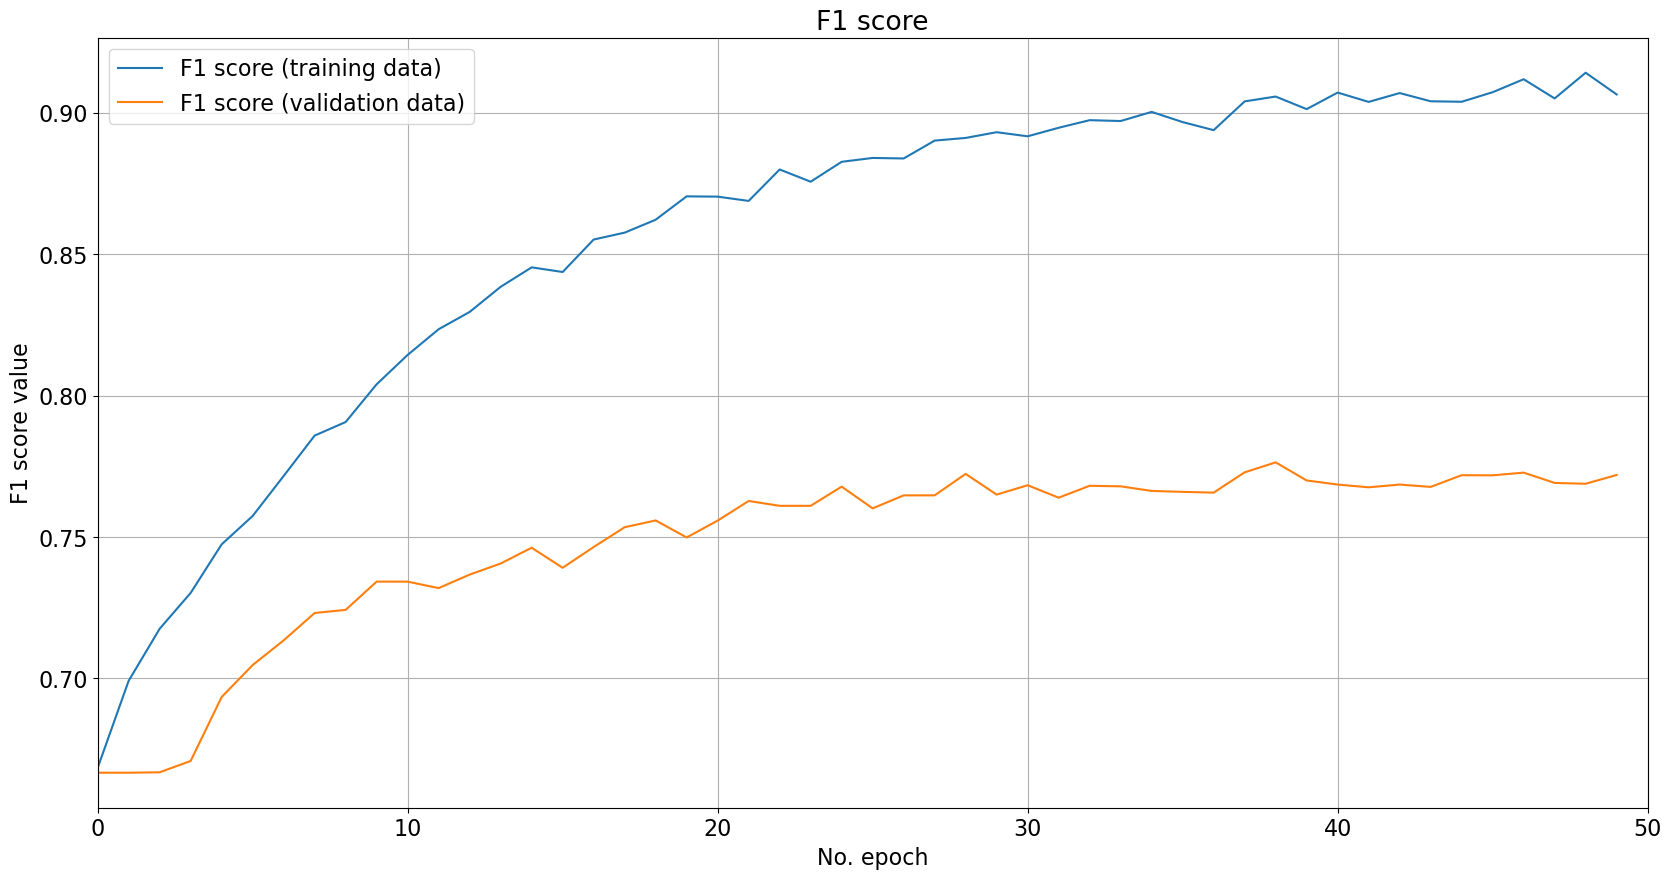

115/115 [==============================] - 0s 822us/step
              precision  recall  f1-score   support
Assistance        0.954   0.921     0.937  1838.000
Slight            0.924   0.956     0.940  1838.000
accuracy          0.939   0.939     0.939     0.939
macro avg         0.939   0.939     0.939  3676.000
weighted avg      0.939   0.939     0.939  3676.000
              precision  recall  f1-score   support
Assistance        0.805   0.764     0.784   811.000
Slight            0.704   0.752     0.727   604.000
accuracy          0.759   0.759     0.759     0.759
macro avg         0.755   0.758     0.756  1415.000
weighted avg      0.762   0.759     0.760  1415.000


In [161]:
if city and cnn2d:

    print("[INFO] evaluating network...")

    Y_predicted = tasp_cnn.predict(x = array_test_images).argmax(axis = 1)

    if train_nn:
        F1_SCORE_PATH = f"{F1_SCORES_PATH}{MODEL_NAME}/"
        F1_SCORE_NAME = f"{city_name}_{MODEL_NAME}_f1_score_paper.svg"

        plot_f1_score_history(f1_score_path = F1_SCORE_PATH,
                              f1_score_name = F1_SCORE_NAME,
                              history = history)

        Y_train_predicted = tasp_cnn.predict(x = array_train_images).argmax(axis = 1)

        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')


## AutoML

In [159]:
city_name

'Southwark'

In [160]:
MODEL_NAME = MODELS_NAME[3]

# Data Summary

## Models times plot

### Sort

In [162]:
times = times.sort_values('time')

### Save csv

In [163]:
SAVE_PATH = f"{REPORTS_TIMES_PATH}{MODEL_TIMESTAMP}.csv"
times.to_csv(SAVE_PATH, index= True)

### Save fig

In [164]:
# LOAD_PATH = f"{REPORTS_TIMES_PATH}2022-05-23-15:28:04.csv"
# times = pd.read_csv(LOAD_PATH)

# ax = sns.barplot(x = 'time',
#                  y = 'model',
#                  palette='deep',
#                  data = times).set(title = f"Models Fitting Time (s)")
# plt.xlabel("Time (s)")

# SAVE_PATH = f"{REPORTS_TIMES_PATH}{MODEL_TIMESTAMP}.png"
# plt.savefig(SAVE_PATH)

## Models metrics file

In [165]:
from os.path import exists

reports_summary = pd.DataFrame()

cities = []
# MODEL_TIMESTAMP = '2022-08-02-10:10:19'

cities.append('leeds')  if leeds else None
cities.append('madrid') if madrid else None
cities.append(f'{city_name}') if UK else None

models_renaming = {'knn': 'KNN',
                   'convolution_1d': '1D-convolution',
                   'convolution_2d': '2D-convolution',
                   'nb': 'NB',
                   'svc': 'SVC',
                   'logistic_regression': 'Logistic-Regression',
                   'random_forest': 'Random-Forest',
                   'mlp': 'ML-Perceptron',                   
                  }
                   # 'auto_ml': 'AutoML'}

splits = ['train', 'test']
sorted_by_time_models_name = times.model

for split in splits:
    reports_summary = pd.DataFrame()

    for model_name in sorted_by_time_models_name:

        REPORT_PATH = f"{REPORTS_PATH}{model_name}/{split}/"

        for city_name in cities:

            REPORT_NAME  = f"{city_name}_{model_name}_report_{MODEL_TIMESTAMP}.csv"

            if exists(REPORT_PATH + REPORT_NAME):
                print(f"Found: {model_name} for {split}")
                report = pd.read_csv(REPORT_PATH + REPORT_NAME, index_col=[0])
                report.insert(0, 'split', split)
                report.insert(1, 'city', city_name)
                report.insert(2, 'model', models_renaming[model_name])

                reports_summary = pd.concat([reports_summary, report])

                reports_summary = reports_summary.sort_values(['city', 'model'], ascending = [True, True])

    if not reports_summary.empty:
        c_m = reports_summary['city'] + '_' + reports_summary['model']
        reports_summary.insert(0, 'c_m', c_m)

        SAVE_PATH =  f"{REPORTS_SUMMARY_PATH}/{split}/{MODEL_TIMESTAMP}.csv"

        reports_summary.insert(0, 'accident_type', reports_summary.index)
        reports_summary.to_csv(SAVE_PATH, index= True)

Found: nb for train
Found: knn for train
Found: logistic_regression for train
Found: random_forest for train
Found: svc for train
Found: mlp for train
Found: convolution_2d for train
Found: nb for test
Found: knn for test
Found: logistic_regression for test
Found: random_forest for test
Found: svc for test
Found: mlp for test
Found: convolution_2d for test


## Models scores plot

In [166]:
REPORT_PATH

'Reports/convolution_2d/test/'

In [167]:
import seaborn as sns

MEASURE_TYPES  = ['precision', 'recall', 'f1-score']
# ACCIDENT_TYPES = ['Slight', 'Serious', 'Fatal']

ACCIDENT_TYPES = ['Slight', 'Assistance']


if leeds:
    leeds_reports_summary  = reports_summary[reports_summary['city'] == 'leeds']
if False: #madrid:
    madrid_reports_summary = reports_summary[reports_summary['city'] == 'madrid']
if UK:
    UK_reports_summary = reports_summary[reports_summary['city'] == city_name]

# print(leeds_reports_summary.loc[ACCIDENT_TYPES])

for split in splits:
    
    REPORT_PATH = f"{REPORTS_SUMMARY_PATH}{split}/{MODEL_TIMESTAMP}.csv"

    if exists(REPORT_PATH):
        fig, axs = plt.subplots(len(MEASURE_TYPES), len(cities), figsize=(15,20))

        print(f"Found: {REPORT_PATH}")

        report = pd.read_csv(REPORT_PATH, index_col=[0])

        if leeds:
            leeds_reports_summary  = report[report['city'] == 'leeds']
        if madrid:
            madrid_reports_summary = report[report['city'] == 'madrid']
        if UK:
            UK_reports_summary = report[report['city'] == city_name]

        for index, measure_type in enumerate(MEASURE_TYPES):

            # Si son dos ciudades el plot es bidimensional.
            if len(cities) > 1:
                axis_leeds = axs[index, 0]
                axis_madrid = axs[index, 1]
            else:
                axis_leeds = axis_madrid = axis_UK = axs[index]

            if leeds:
                ax = sns.barplot(x = 'accident_type',
                                 y = measure_type,
                                 hue = 'model',
                                 palette = 'deep',
                                 data = leeds_reports_summary.loc[ACCIDENT_TYPES],
                                 ax = axis_leeds).set(title = f"{measure_type} Leeds")


            if madrid:
                ax = sns.barplot(x = 'accident_type',
                                 y = measure_type,
                                 hue = 'model',
                                 palette = 'deep',
                                 data = madrid_reports_summary.loc[ACCIDENT_TYPES],
                                 ax = axis_madrid).set(title = f"{measure_type} Madrid")
            
            if UK:
                ax = sns.barplot(x = 'accident_type',
                                 y = measure_type,
                                 hue = 'model',
                                 palette = 'deep',
                                 data = UK_reports_summary.loc[ACCIDENT_TYPES],
                                 ax = axis_UK).set(title = f"{measure_type} {city_name}")                

        SAVE_PATH = f"{REPORTS_SUMMARY_PATH}{split}/{MODEL_TIMESTAMP}.png"

        fig = fig.get_figure()
        fig.savefig(SAVE_PATH)

Found: Reports/summary/train/2023-10-10-00:15:31.csv
Found: Reports/summary/test/2023-10-10-00:15:31.csv


In [168]:
city_name

'Victoria'

In [169]:
MODEL_TIMESTAMP

'2023-10-10-00:15:31'

In [170]:
import pandas as pd
import matplotlib.pyplot as plt

root_path = 'Reports/summary/test/'

all_cities_summaries = pd.DataFrame()

best_results_mapper = {'Birmingham': '2023-08-18-15:47:06',
                       'Sheffield':  '2023-08-18-17:08:06',
                       'Liverpool':  '2023-08-18-15:25:24',
                       'Southwark':  '2023-08-18-18:08:44',
                       'Manchester': '2023-08-18-17:44:54',
                       'Cornwall':   '2023-07-15-15:49:36'
                     }

for city_name, city_timestamp in best_results_mapper.items():
    city_summary = pd.read_csv(f"{root_path}/{city_timestamp}.csv", index_col=0)
    all_cities_summaries = pd.concat([all_cities_summaries, city_summary])

all_cities_summaries = all_cities_summaries.drop_duplicates()

casualty_types = ['Slight']

all_cities_summaries = all_cities_summaries[all_cities_summaries['model'] != '1D-convolution']
all_cities_summaries.index = all_cities_summaries.city

for casualty_type in casualty_types:
    current_casualty_type_all_cities_summaries = all_cities_summaries[all_cities_summaries['accident_type'] == casualty_type]


    current_casualty_type_all_cities_summaries.groupby('model')['f1-score'].plot(x='city', legend=True, figsize=(20, 10), title=f'Models F1-scores by city ({casualty_type} Accidents)', grid=True)
    plt.ylabel('F1-Score')
    plt.savefig(f"{casualty_type}_a.svg")

In [171]:
all_cities_summaries

,accident_type,c_m,split,city,model,precision,recall,f1-score,support
city,,,,,,,,,
Birmingham,Assistance,Birmingham_2D-convolution,test,Birmingham,2D-convolution,0.729,0.693,0.711,688.000
Birmingham,Slight,Birmingham_2D-convolution,test,Birmingham,2D-convolution,0.848,0.869,0.858,1350.000
Birmingham,accuracy,Birmingham_2D-convolution,test,Birmingham,2D-convolution,0.810,0.810,0.810,0.810
Birmingham,macro avg,Birmingham_2D-convolution,test,Birmingham,2D-convolution,0.788,0.781,0.784,2038.000
Birmingham,weighted avg,Birmingham_2D-convolution,test,Birmingham,2D-convolution,0.808,0.810,0.808,2038.000
...,...,...,...,...,...,...,...,...,...
Cornwall,Assistance,Cornwall_SVC,test,Cornwall,SVC,0.709,0.625,0.664,855.000
Cornwall,Slight,Cornwall_SVC,test,Cornwall,SVC,0.695,0.769,0.730,950.000
Cornwall,accuracy,Cornwall_SVC,test,Cornwall,SVC,0.701,0.701,0.701,0.701
